In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays
from IPython.core.debugger import set_trace

import utils

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
from tqdm import tqdm_notebook
import collections
import os
import random
import time
import math
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Datasets and Preprocessing

## FB15K-237

In [7]:
%%bash

# Download and unzip FB15K-237.
#cd ../data
#mkdir fb15k-237
#cd fb15k-237
#wget https://download.microsoft.com/download/8/7/0/8700516A-AB3D-4850-B4BB-805C515AECE1/FB15K-237.2.zip
#unzip FB15K-237.2.zip

In [4]:
fb_dir = '../data/fb15k-237/Release'

In [5]:
train_triples = pd.read_csv(os.path.join(fb_dir, 'train.txt'), sep='\t', names=['subject', 'relation', 'object'])
val_triples = pd.read_csv(os.path.join(fb_dir, 'valid.txt'), sep='\t', names=['subject', 'relation', 'object'])
test_triples = pd.read_csv(os.path.join(fb_dir, 'test.txt'), sep='\t', names=['subject', 'relation', 'object'])
print(len(train_triples), len(val_triples), len(test_triples))
train_triples.head()

272115 17535 20466


,subject,relation,object
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8


In [6]:
entity_map = utils.IndexMap(train_triples[['subject', 'object']], 
                            val_triples[['subject', 'object']], 
                            test_triples[['subject', 'object']])

num_nodes = len(entity_map)
num_nodes

14541

In [7]:
feat_data = np.eye(num_nodes)

In [8]:
# For non-relational model.
adj_lists = collections.defaultdict(set)
for i, row in tqdm_notebook(train_triples.iterrows(), total=len(train_triples)):
    subject_index = entity_map.to_index(row['subject'])
    object_index = entity_map.to_index(row['object'])
    # Use non-directed edges here.
    adj_lists[subject_index].add(object_index)
    adj_lists[object_index].add(subject_index)

HBox(children=(IntProgress(value=0, max=272115), HTML(value=u'')))

KeyboardInterrupt: 

In [8]:
# For relational model.
relation_map = utils.IndexMap(train_triples['relation'], 
                              val_triples['relation'], 
                              test_triples['relation'])
num_relations = len(relation_map)
print(num_relations)

237


In [9]:
# Old version which stores one relation per edge.
relational_adj_dict = collections.defaultdict(lambda: collections.defaultdict(list))
counter_overwrite = 0
for i, row in tqdm_notebook(train_triples.iterrows(), total=len(train_triples)):
    subject_index = entity_map.to_index(row['subject'])
    object_index = entity_map.to_index(row['object'])
    relation_index = relation_map.to_index(row['relation'])
    
    if object_index in relational_adj_dict[subject_index]:
        print('Edge {} -> {} exists with relation {}, will be overwritten by new relation {}'.format(subject_index, object_index, relational_adj_dict[subject_index][object_index], relation_index))
        counter_overwrite += 1
    relational_adj_dict[subject_index][object_index] = relation_index
    # TODO: Check if it works better with undirected edges.
    #relational_adj_dict[object_index][subject_index] = relation_index

HBox(children=(IntProgress(value=0, max=272115), HTML(value=u'')))

Edge 11182 -> 10416 exists with relation 96, will be overwritten by new relation 73
Edge 10166 -> 10416 exists with relation 96, will be overwritten by new relation 73
Edge 9115 -> 12469 exists with relation 158, will be overwritten by new relation 157
Edge 13266 -> 3242 exists with relation 230, will be overwritten by new relation 14
Edge 2732 -> 4800 exists with relation 10, will be overwritten by new relation 12
Edge 3420 -> 5571 exists with relation 98, will be overwritten by new relation 99
Edge 1085 -> 7161 exists with relation 12, will be overwritten by new relation 10
Edge 5860 -> 11709 exists with relation 200, will be overwritten by new relation 199
Edge 3233 -> 14196 exists with relation 173, will be overwritten by new relation 171
Edge 4571 -> 7924 exists with relation 12, will be overwritten by new relation 10
Edge 6626 -> 10416 exists with relation 119, will be overwritten by new relation 19
Edge 3731 -> 3730 exists with relation 12, will be overwritten by new relation 10

Edge 13324 -> 8588 exists with relation 81, will be overwritten by new relation 14
Edge 13440 -> 9314 exists with relation 234, will be overwritten by new relation 162
Edge 14060 -> 10319 exists with relation 11, will be overwritten by new relation 68
Edge 1973 -> 8671 exists with relation 14, will be overwritten by new relation 92
Edge 2913 -> 8552 exists with relation 10, will be overwritten by new relation 12
Edge 3622 -> 7864 exists with relation 12, will be overwritten by new relation 10
Edge 13167 -> 10310 exists with relation 10, will be overwritten by new relation 12
Edge 5088 -> 7716 exists with relation 12, will be overwritten by new relation 10
Edge 9047 -> 3629 exists with relation 99, will be overwritten by new relation 92
Edge 9595 -> 9125 exists with relation 10, will be overwritten by new relation 12
Edge 2652 -> 2777 exists with relation 32, will be overwritten by new relation 195
Edge 5317 -> 10559 exists with relation 138, will be overwritten by new relation 132
Edge

Edge 13140 -> 2309 exists with relation 98, will be overwritten by new relation 99
Edge 406 -> 3945 exists with relation 11, will be overwritten by new relation 68
Edge 9905 -> 7684 exists with relation 155, will be overwritten by new relation 157
Edge 5548 -> 5050 exists with relation 200, will be overwritten by new relation 199
Edge 2256 -> 12086 exists with relation 121, will be overwritten by new relation 129
Edge 13197 -> 2042 exists with relation 24, will be overwritten by new relation 145
Edge 10036 -> 7127 exists with relation 11, will be overwritten by new relation 68
Edge 11259 -> 5403 exists with relation 14, will be overwritten by new relation 87
Edge 531 -> 10483 exists with relation 11, will be overwritten by new relation 68
Edge 6001 -> 4906 exists with relation 10, will be overwritten by new relation 48
Edge 6314 -> 7128 exists with relation 12, will be overwritten by new relation 10
Edge 6225 -> 2716 exists with relation 10, will be overwritten by new relation 12
Edge 

Edge 12960 -> 8891 exists with relation 211, will be overwritten by new relation 212
Edge 552 -> 10559 exists with relation 63, will be overwritten by new relation 46
Edge 4077 -> 1183 exists with relation 11, will be overwritten by new relation 223
Edge 2916 -> 12242 exists with relation 190, will be overwritten by new relation 189
Edge 6569 -> 10416 exists with relation 118, will be overwritten by new relation 22
Edge 610 -> 1504 exists with relation 10, will be overwritten by new relation 12
Edge 8823 -> 10190 exists with relation 10, will be overwritten by new relation 12
Edge 5586 -> 5855 exists with relation 31, will be overwritten by new relation 32
Edge 6072 -> 13654 exists with relation 190, will be overwritten by new relation 147
Edge 3165 -> 6636 exists with relation 179, will be overwritten by new relation 190
Edge 1808 -> 8882 exists with relation 190, will be overwritten by new relation 180
Edge 4351 -> 4158 exists with relation 12, will be overwritten by new relation 10


Edge 6819 -> 9808 exists with relation 75, will be overwritten by new relation 96
Edge 9979 -> 10416 exists with relation 118, will be overwritten by new relation 19
Edge 2993 -> 9985 exists with relation 232, will be overwritten by new relation 225
Edge 1874 -> 3997 exists with relation 200, will be overwritten by new relation 199
Edge 4025 -> 5050 exists with relation 200, will be overwritten by new relation 199
Edge 7684 -> 12329 exists with relation 157, will be overwritten by new relation 158
Edge 11868 -> 8519 exists with relation 157, will be overwritten by new relation 158
Edge 1684 -> 8542 exists with relation 118, will be overwritten by new relation 19
Edge 979 -> 9536 exists with relation 158, will be overwritten by new relation 155
Edge 9796 -> 3942 exists with relation 95, will be overwritten by new relation 74
Edge 14269 -> 1422 exists with relation 162, will be overwritten by new relation 234
Edge 9665 -> 12133 exists with relation 10, will be overwritten by new relation

Edge 10029 -> 4320 exists with relation 0, will be overwritten by new relation 212
Edge 12315 -> 4320 exists with relation 0, will be overwritten by new relation 211
Edge 5773 -> 7684 exists with relation 148, will be overwritten by new relation 152
Edge 6652 -> 11361 exists with relation 10, will be overwritten by new relation 12
Edge 14271 -> 9323 exists with relation 162, will be overwritten by new relation 234
Edge 10008 -> 4700 exists with relation 10, will be overwritten by new relation 12
Edge 7144 -> 5625 exists with relation 152, will be overwritten by new relation 148
Edge 13030 -> 6211 exists with relation 234, will be overwritten by new relation 162
Edge 6925 -> 11649 exists with relation 91, will be overwritten by new relation 8
Edge 4403 -> 6507 exists with relation 155, will be overwritten by new relation 157
Edge 6588 -> 7889 exists with relation 158, will be overwritten by new relation 157
Edge 4571 -> 4572 exists with relation 10, will be overwritten by new relation 1

Edge 4403 -> 11870 exists with relation 155, will be overwritten by new relation 157
Edge 11573 -> 3094 exists with relation 198, will be overwritten by new relation 201
Edge 14344 -> 10387 exists with relation 14, will be overwritten by new relation 229
Edge 2584 -> 9630 exists with relation 12, will be overwritten by new relation 10
Edge 2522 -> 7019 exists with relation 12, will be overwritten by new relation 10
Edge 11857 -> 11809 exists with relation 11, will be overwritten by new relation 68
Edge 1290 -> 7106 exists with relation 102, will be overwritten by new relation 140
Edge 5362 -> 10559 exists with relation 43, will be overwritten by new relation 45
Edge 6085 -> 11098 exists with relation 10, will be overwritten by new relation 12
Edge 8389 -> 8823 exists with relation 230, will be overwritten by new relation 14
Edge 13303 -> 8810 exists with relation 10, will be overwritten by new relation 12
Edge 2725 -> 10328 exists with relation 190, will be overwritten by new relation 

Edge 12224 -> 8891 exists with relation 212, will be overwritten by new relation 211
Edge 7706 -> 4366 exists with relation 86, will be overwritten by new relation 228
Edge 5149 -> 8891 exists with relation 212, will be overwritten by new relation 0
Edge 5057 -> 308 exists with relation 157, will be overwritten by new relation 158
Edge 3360 -> 10197 exists with relation 11, will be overwritten by new relation 68
Edge 11524 -> 14269 exists with relation 163, will be overwritten by new relation 165
Edge 987 -> 13358 exists with relation 116, will be overwritten by new relation 10
Edge 8748 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 7848 -> 11408 exists with relation 10, will be overwritten by new relation 12
Edge 9115 -> 6588 exists with relation 157, will be overwritten by new relation 158
Edge 2504 -> 5851 exists with relation 73, will be overwritten by new relation 96
Edge 8633 -> 10559 exists with relation 45, will be overwritten by new relation 46


Edge 6559 -> 10559 exists with relation 132, will be overwritten by new relation 133
Edge 727 -> 4131 exists with relation 10, will be overwritten by new relation 12
Edge 519 -> 11352 exists with relation 10, will be overwritten by new relation 12
Edge 44 -> 4706 exists with relation 200, will be overwritten by new relation 199
Edge 646 -> 7912 exists with relation 10, will be overwritten by new relation 12
Edge 960 -> 9276 exists with relation 10, will be overwritten by new relation 12
Edge 14299 -> 10050 exists with relation 68, will be overwritten by new relation 11
Edge 13030 -> 7145 exists with relation 162, will be overwritten by new relation 234
Edge 8339 -> 9574 exists with relation 115, will be overwritten by new relation 10
Edge 10944 -> 4723 exists with relation 12, will be overwritten by new relation 10
Edge 10868 -> 7163 exists with relation 10, will be overwritten by new relation 12
Edge 4403 -> 8056 exists with relation 157, will be overwritten by new relation 158
Edge 7

Edge 3278 -> 12490 exists with relation 70, will be overwritten by new relation 68
Edge 11813 -> 337 exists with relation 14, will be overwritten by new relation 87
Edge 8901 -> 10559 exists with relation 132, will be overwritten by new relation 134
Edge 12093 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 2311 -> 13161 exists with relation 70, will be overwritten by new relation 11
Edge 63 -> 10308 exists with relation 88, will be overwritten by new relation 14
Edge 2673 -> 4533 exists with relation 14, will be overwritten by new relation 77
Edge 9122 -> 10559 exists with relation 132, will be overwritten by new relation 134
Edge 4759 -> 6206 exists with relation 68, will be overwritten by new relation 11
Edge 11611 -> 7507 exists with relation 10, will be overwritten by new relation 12
Edge 8015 -> 8068 exists with relation 10, will be overwritten by new relation 12
Edge 1333 -> 1985 exists with relation 12, will be overwritten by new relation 10
Edge 3

Edge 12460 -> 11028 exists with relation 99, will be overwritten by new relation 14
Edge 10886 -> 7756 exists with relation 68, will be overwritten by new relation 11
Edge 8095 -> 7285 exists with relation 8, will be overwritten by new relation 15
Edge 1162 -> 1716 exists with relation 68, will be overwritten by new relation 11
Edge 12521 -> 8367 exists with relation 14, will be overwritten by new relation 84
Edge 10586 -> 5831 exists with relation 12, will be overwritten by new relation 232
Edge 349 -> 4552 exists with relation 63, will be overwritten by new relation 66
Edge 4639 -> 4639 exists with relation 60, will be overwritten by new relation 55
Edge 6902 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 3644 -> 791 exists with relation 198, will be overwritten by new relation 201
Edge 12528 -> 1518 exists with relation 232, will be overwritten by new relation 11
Edge 11977 -> 6489 exists with relation 77, will be overwritten by new relation 14
Edge 30

Edge 3788 -> 10779 exists with relation 189, will be overwritten by new relation 190
Edge 2245 -> 6151 exists with relation 223, will be overwritten by new relation 225
Edge 3598 -> 10052 exists with relation 12, will be overwritten by new relation 10
Edge 10518 -> 3973 exists with relation 80, will be overwritten by new relation 96
Edge 4755 -> 2168 exists with relation 11, will be overwritten by new relation 68
Edge 5807 -> 10559 exists with relation 66, will be overwritten by new relation 168
Edge 12770 -> 12994 exists with relation 163, will be overwritten by new relation 165
Edge 5958 -> 10759 exists with relation 12, will be overwritten by new relation 10
Edge 486 -> 5653 exists with relation 10, will be overwritten by new relation 12
Edge 13562 -> 8857 exists with relation 129, will be overwritten by new relation 139
Edge 3016 -> 13363 exists with relation 152, will be overwritten by new relation 148
Edge 7728 -> 11523 exists with relation 118, will be overwritten by new relatio

Edge 830 -> 4089 exists with relation 99, will be overwritten by new relation 92
Edge 1891 -> 3997 exists with relation 200, will be overwritten by new relation 199
Edge 10896 -> 11709 exists with relation 200, will be overwritten by new relation 199
Edge 12335 -> 6507 exists with relation 157, will be overwritten by new relation 158
Edge 3114 -> 7867 exists with relation 12, will be overwritten by new relation 10
Edge 6376 -> 4706 exists with relation 199, will be overwritten by new relation 200
Edge 13414 -> 9432 exists with relation 10, will be overwritten by new relation 12
Edge 1089 -> 10559 exists with relation 134, will be overwritten by new relation 132
Edge 9750 -> 8187 exists with relation 10, will be overwritten by new relation 12
Edge 716 -> 10559 exists with relation 135, will be overwritten by new relation 132
Edge 13821 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 13145 -> 8214 exists with relation 11, will be overwritten by new relation 

Edge 1861 -> 2181 exists with relation 65, will be overwritten by new relation 63
Edge 13838 -> 9650 exists with relation 234, will be overwritten by new relation 162
Edge 6070 -> 11442 exists with relation 189, will be overwritten by new relation 147
Edge 4403 -> 6513 exists with relation 157, will be overwritten by new relation 158
Edge 1064 -> 10416 exists with relation 96, will be overwritten by new relation 73
Edge 13352 -> 10559 exists with relation 168, will be overwritten by new relation 43
Edge 2649 -> 5673 exists with relation 11, will be overwritten by new relation 68
Edge 4729 -> 4729 exists with relation 60, will be overwritten by new relation 55
Edge 2159 -> 8873 exists with relation 12, will be overwritten by new relation 10
Edge 4471 -> 13876 exists with relation 129, will be overwritten by new relation 124
Edge 7091 -> 4706 exists with relation 199, will be overwritten by new relation 200
Edge 11122 -> 9521 exists with relation 129, will be overwritten by new relation 

Edge 14418 -> 2529 exists with relation 190, will be overwritten by new relation 189
Edge 73 -> 11138 exists with relation 14, will be overwritten by new relation 92
Edge 2996 -> 10813 exists with relation 88, will be overwritten by new relation 14
Edge 12802 -> 9789 exists with relation 99, will be overwritten by new relation 14
Edge 8873 -> 12691 exists with relation 11, will be overwritten by new relation 68
Edge 13504 -> 10559 exists with relation 168, will be overwritten by new relation 66
Edge 8502 -> 10559 exists with relation 134, will be overwritten by new relation 135
Edge 1085 -> 2204 exists with relation 10, will be overwritten by new relation 31
Edge 8028 -> 5050 exists with relation 199, will be overwritten by new relation 200
Edge 10586 -> 9917 exists with relation 33, will be overwritten by new relation 10
Edge 14265 -> 10688 exists with relation 234, will be overwritten by new relation 162
Edge 9563 -> 6435 exists with relation 77, will be overwritten by new relation 1

Edge 2103 -> 10559 exists with relation 46, will be overwritten by new relation 45
Edge 860 -> 10559 exists with relation 168, will be overwritten by new relation 66
Edge 2158 -> 10559 exists with relation 132, will be overwritten by new relation 133
Edge 11548 -> 7198 exists with relation 198, will be overwritten by new relation 201
Edge 1082 -> 3278 exists with relation 229, will be overwritten by new relation 230
Edge 2054 -> 7939 exists with relation 189, will be overwritten by new relation 190
Edge 8038 -> 12175 exists with relation 10, will be overwritten by new relation 12
Edge 2854 -> 5418 exists with relation 10, will be overwritten by new relation 12
Edge 4699 -> 10559 exists with relation 63, will be overwritten by new relation 168
Edge 336 -> 9853 exists with relation 222, will be overwritten by new relation 140
Edge 12650 -> 10416 exists with relation 96, will be overwritten by new relation 73
Edge 5558 -> 7608 exists with relation 11, will be overwritten by new relation 1

Edge 991 -> 8099 exists with relation 190, will be overwritten by new relation 194
Edge 12631 -> 3596 exists with relation 92, will be overwritten by new relation 99
Edge 3734 -> 5831 exists with relation 11, will be overwritten by new relation 225
Edge 568 -> 12134 exists with relation 129, will be overwritten by new relation 20
Edge 11839 -> 9271 exists with relation 190, will be overwritten by new relation 189
Edge 5437 -> 10559 exists with relation 46, will be overwritten by new relation 66
Edge 4876 -> 4939 exists with relation 10, will be overwritten by new relation 12
Edge 3340 -> 3470 exists with relation 79, will be overwritten by new relation 98
Edge 11476 -> 10559 exists with relation 46, will be overwritten by new relation 43
Edge 2406 -> 4651 exists with relation 11, will be overwritten by new relation 68
Edge 2239 -> 7698 exists with relation 32, will be overwritten by new relation 33
Edge 10029 -> 10199 exists with relation 0, will be overwritten by new relation 211
Edge

Edge 10448 -> 10448 exists with relation 60, will be overwritten by new relation 51
Edge 3601 -> 5050 exists with relation 199, will be overwritten by new relation 200
Edge 6970 -> 7743 exists with relation 11, will be overwritten by new relation 68
Edge 1643 -> 13485 exists with relation 190, will be overwritten by new relation 189
Edge 9220 -> 10559 exists with relation 133, will be overwritten by new relation 135
Edge 8003 -> 7752 exists with relation 129, will be overwritten by new relation 20
Edge 11098 -> 9138 exists with relation 12, will be overwritten by new relation 10
Edge 7660 -> 6551 exists with relation 12, will be overwritten by new relation 10
Edge 10171 -> 7572 exists with relation 198, will be overwritten by new relation 201
Edge 8266 -> 4321 exists with relation 0, will be overwritten by new relation 212
Edge 1910 -> 646 exists with relation 10, will be overwritten by new relation 12
Edge 5608 -> 3997 exists with relation 200, will be overwritten by new relation 199


Edge 477 -> 13241 exists with relation 165, will be overwritten by new relation 163
Edge 5046 -> 11080 exists with relation 12, will be overwritten by new relation 10
Edge 13272 -> 11962 exists with relation 11, will be overwritten by new relation 68
Edge 4230 -> 2181 exists with relation 65, will be overwritten by new relation 168
Edge 2314 -> 476 exists with relation 49, will be overwritten by new relation 32
Edge 147 -> 10559 exists with relation 46, will be overwritten by new relation 66
Edge 2002 -> 1953 exists with relation 10, will be overwritten by new relation 12
Edge 4485 -> 8460 exists with relation 12, will be overwritten by new relation 10
Edge 4091 -> 4709 exists with relation 227, will be overwritten by new relation 85
Edge 990 -> 6940 exists with relation 12, will be overwritten by new relation 10
Edge 878 -> 8498 exists with relation 12, will be overwritten by new relation 10
Edge 4110 -> 10559 exists with relation 63, will be overwritten by new relation 66
Edge 856 ->

Edge 6004 -> 10559 exists with relation 46, will be overwritten by new relation 63
Edge 8708 -> 10527 exists with relation 47, will be overwritten by new relation 177
Edge 11983 -> 11962 exists with relation 11, will be overwritten by new relation 68
Edge 375 -> 13986 exists with relation 189, will be overwritten by new relation 190
Edge 1858 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 3432 -> 12467 exists with relation 100, will be overwritten by new relation 11
Edge 12994 -> 9648 exists with relation 162, will be overwritten by new relation 234
Edge 5807 -> 5807 exists with relation 55, will be overwritten by new relation 60
Edge 3525 -> 1179 exists with relation 232, will be overwritten by new relation 11
Edge 5488 -> 4992 exists with relation 10, will be overwritten by new relation 12
Edge 10217 -> 5050 exists with relation 200, will be overwritten by new relation 199
Edge 7017 -> 10530 exists with relation 31, will be overwritten by new relation 3

Edge 11740 -> 11709 exists with relation 199, will be overwritten by new relation 200
Edge 1137 -> 3997 exists with relation 199, will be overwritten by new relation 200
Edge 3798 -> 10559 exists with relation 43, will be overwritten by new relation 63
Edge 10014 -> 12889 exists with relation 198, will be overwritten by new relation 201
Edge 7842 -> 11442 exists with relation 190, will be overwritten by new relation 189
Edge 11239 -> 3973 exists with relation 190, will be overwritten by new relation 189
Edge 5465 -> 5466 exists with relation 195, will be overwritten by new relation 49
Edge 11313 -> 13752 exists with relation 11, will be overwritten by new relation 68
Edge 1692 -> 2531 exists with relation 10, will be overwritten by new relation 12
Edge 6285 -> 5631 exists with relation 68, will be overwritten by new relation 11
Edge 10242 -> 10653 exists with relation 11, will be overwritten by new relation 68
Edge 1479 -> 3997 exists with relation 200, will be overwritten by new relat

Edge 7062 -> 5050 exists with relation 199, will be overwritten by new relation 200
Edge 8176 -> 10559 exists with relation 134, will be overwritten by new relation 135
Edge 3789 -> 111 exists with relation 10, will be overwritten by new relation 12
Edge 1072 -> 4706 exists with relation 200, will be overwritten by new relation 199
Edge 4642 -> 10559 exists with relation 43, will be overwritten by new relation 45
Edge 11904 -> 10559 exists with relation 63, will be overwritten by new relation 168
Edge 2359 -> 5619 exists with relation 195, will be overwritten by new relation 32
Edge 13963 -> 11495 exists with relation 11, will be overwritten by new relation 68
Edge 4994 -> 8334 exists with relation 99, will be overwritten by new relation 98
Edge 7862 -> 4706 exists with relation 199, will be overwritten by new relation 200
Edge 12886 -> 11857 exists with relation 12, will be overwritten by new relation 10
Edge 8268 -> 3382 exists with relation 212, will be overwritten by new relation 0

Edge 12815 -> 10416 exists with relation 118, will be overwritten by new relation 19
Edge 218 -> 3807 exists with relation 198, will be overwritten by new relation 201
Edge 5323 -> 6871 exists with relation 68, will be overwritten by new relation 11
Edge 1939 -> 5286 exists with relation 68, will be overwritten by new relation 11
Edge 8384 -> 2842 exists with relation 12, will be overwritten by new relation 10
Edge 10752 -> 7009 exists with relation 229, will be overwritten by new relation 14
Edge 4832 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 12858 -> 4706 exists with relation 200, will be overwritten by new relation 199
Edge 3889 -> 8600 exists with relation 14, will be overwritten by new relation 229
Edge 11040 -> 6514 exists with relation 10, will be overwritten by new relation 12
Edge 1085 -> 12768 exists with relation 32, will be overwritten by new relation 195
Edge 12328 -> 10559 exists with relation 45, will be overwritten by new relation 43


Edge 7122 -> 6429 exists with relation 82, will be overwritten by new relation 94
Edge 11272 -> 11429 exists with relation 101, will be overwritten by new relation 11
Edge 11800 -> 3821 exists with relation 14, will be overwritten by new relation 88
Edge 397 -> 10416 exists with relation 188, will be overwritten by new relation 112
Edge 1949 -> 11286 exists with relation 190, will be overwritten by new relation 189
Edge 127 -> 10559 exists with relation 63, will be overwritten by new relation 45
Edge 8648 -> 12901 exists with relation 190, will be overwritten by new relation 147
Edge 10911 -> 10416 exists with relation 96, will be overwritten by new relation 73
Edge 9972 -> 8335 exists with relation 11, will be overwritten by new relation 70
Edge 6214 -> 10559 exists with relation 63, will be overwritten by new relation 43
Edge 4714 -> 2088 exists with relation 10, will be overwritten by new relation 12
Edge 2683 -> 12469 exists with relation 158, will be overwritten by new relation 15

Edge 6390 -> 7268 exists with relation 12, will be overwritten by new relation 10
Edge 9125 -> 2950 exists with relation 12, will be overwritten by new relation 10
Edge 6214 -> 10559 exists with relation 43, will be overwritten by new relation 46
Edge 2932 -> 2528 exists with relation 190, will be overwritten by new relation 189
Edge 7575 -> 4706 exists with relation 200, will be overwritten by new relation 199
Edge 7020 -> 5895 exists with relation 12, will be overwritten by new relation 10
Edge 12778 -> 11286 exists with relation 190, will be overwritten by new relation 189
Edge 8049 -> 2392 exists with relation 211, will be overwritten by new relation 0
Edge 10618 -> 3973 exists with relation 189, will be overwritten by new relation 180
Edge 4493 -> 929 exists with relation 158, will be overwritten by new relation 157
Edge 1290 -> 11311 exists with relation 140, will be overwritten by new relation 102
Edge 11993 -> 8362 exists with relation 10, will be overwritten by new relation 12

Edge 2282 -> 4158 exists with relation 12, will be overwritten by new relation 10
Edge 10240 -> 4551 exists with relation 10, will be overwritten by new relation 12
Edge 6688 -> 6688 exists with relation 55, will be overwritten by new relation 60
Edge 8378 -> 9808 exists with relation 118, will be overwritten by new relation 22
Edge 8596 -> 5050 exists with relation 200, will be overwritten by new relation 199
Edge 5850 -> 4073 exists with relation 70, will be overwritten by new relation 11
Edge 5944 -> 12158 exists with relation 11, will be overwritten by new relation 68
Edge 6373 -> 12023 exists with relation 49, will be overwritten by new relation 195
Edge 8519 -> 1916 exists with relation 154, will be overwritten by new relation 149
Edge 8605 -> 13030 exists with relation 163, will be overwritten by new relation 165
Edge 5480 -> 10559 exists with relation 168, will be overwritten by new relation 45
Edge 12023 -> 5447 exists with relation 223, will be overwritten by new relation 11


Edge 12316 -> 13752 exists with relation 11, will be overwritten by new relation 68
Edge 4086 -> 10559 exists with relation 65, will be overwritten by new relation 63
Edge 12351 -> 3973 exists with relation 190, will be overwritten by new relation 189
Edge 1916 -> 10909 exists with relation 8, will be overwritten by new relation 12
Edge 6578 -> 10559 exists with relation 46, will be overwritten by new relation 43
Edge 8266 -> 4883 exists with relation 212, will be overwritten by new relation 211
Edge 832 -> 11385 exists with relation 12, will be overwritten by new relation 10
Edge 1924 -> 11963 exists with relation 12, will be overwritten by new relation 10
Edge 2076 -> 10062 exists with relation 32, will be overwritten by new relation 49
Edge 5526 -> 11241 exists with relation 11, will be overwritten by new relation 68
Edge 5047 -> 8914 exists with relation 15, will be overwritten by new relation 8
Edge 13317 -> 12003 exists with relation 98, will be overwritten by new relation 14
Edg

Edge 4344 -> 10559 exists with relation 168, will be overwritten by new relation 66
Edge 11520 -> 9214 exists with relation 165, will be overwritten by new relation 163
Edge 5975 -> 5974 exists with relation 12, will be overwritten by new relation 10
Edge 3984 -> 7166 exists with relation 12, will be overwritten by new relation 10
Edge 13970 -> 12470 exists with relation 8, will be overwritten by new relation 12
Edge 4823 -> 10559 exists with relation 46, will be overwritten by new relation 66
Edge 9810 -> 12227 exists with relation 10, will be overwritten by new relation 33
Edge 6938 -> 12469 exists with relation 158, will be overwritten by new relation 157
Edge 5451 -> 4706 exists with relation 200, will be overwritten by new relation 199
Edge 3650 -> 7602 exists with relation 212, will be overwritten by new relation 211
Edge 13112 -> 839 exists with relation 11, will be overwritten by new relation 70
Edge 2429 -> 3973 exists with relation 189, will be overwritten by new relation 190

Edge 13202 -> 10416 exists with relation 73, will be overwritten by new relation 97
Edge 11464 -> 3997 exists with relation 199, will be overwritten by new relation 200
Edge 1029 -> 9271 exists with relation 190, will be overwritten by new relation 189
Edge 6914 -> 4706 exists with relation 199, will be overwritten by new relation 200
Edge 6261 -> 3973 exists with relation 189, will be overwritten by new relation 190
Edge 7962 -> 7744 exists with relation 101, will be overwritten by new relation 11
Edge 13414 -> 11747 exists with relation 68, will be overwritten by new relation 11
Edge 11732 -> 13783 exists with relation 125, will be overwritten by new relation 120
Edge 3282 -> 10559 exists with relation 46, will be overwritten by new relation 168
Edge 7750 -> 10559 exists with relation 133, will be overwritten by new relation 132
Edge 4466 -> 7161 exists with relation 12, will be overwritten by new relation 10
Edge 8909 -> 10559 exists with relation 66, will be overwritten by new rela

Edge 5895 -> 7020 exists with relation 10, will be overwritten by new relation 12
Edge 11979 -> 12687 exists with relation 68, will be overwritten by new relation 11
Edge 1584 -> 5585 exists with relation 10, will be overwritten by new relation 12
Edge 9364 -> 1405 exists with relation 198, will be overwritten by new relation 201
Edge 9339 -> 7807 exists with relation 189, will be overwritten by new relation 188
Edge 12545 -> 4130 exists with relation 11, will be overwritten by new relation 68
Edge 406 -> 1197 exists with relation 11, will be overwritten by new relation 68
Edge 11253 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 6830 -> 369 exists with relation 99, will be overwritten by new relation 92
Edge 3563 -> 9578 exists with relation 174, will be overwritten by new relation 171
Edge 9972 -> 4884 exists with relation 70, will be overwritten by new relation 11
Edge 3591 -> 1513 exists with relation 190, will be overwritten by new relation 189
Edge 

Edge 4696 -> 4706 exists with relation 199, will be overwritten by new relation 200
Edge 9024 -> 7995 exists with relation 225, will be overwritten by new relation 11
Edge 7794 -> 9789 exists with relation 79, will be overwritten by new relation 99
Edge 8369 -> 11524 exists with relation 118, will be overwritten by new relation 19
Edge 4653 -> 7816 exists with relation 68, will be overwritten by new relation 11
Edge 9367 -> 10351 exists with relation 14, will be overwritten by new relation 99
Edge 6370 -> 7928 exists with relation 11, will be overwritten by new relation 222
Edge 7272 -> 4706 exists with relation 199, will be overwritten by new relation 200
Edge 9700 -> 12905 exists with relation 225, will be overwritten by new relation 11
Edge 8091 -> 5673 exists with relation 11, will be overwritten by new relation 68
Edge 1734 -> 6286 exists with relation 12, will be overwritten by new relation 10
Edge 1156 -> 10559 exists with relation 168, will be overwritten by new relation 45
Edg

Edge 6001 -> 9665 exists with relation 10, will be overwritten by new relation 12
Edge 13644 -> 1409 exists with relation 70, will be overwritten by new relation 11
Edge 2716 -> 379 exists with relation 68, will be overwritten by new relation 11
Edge 8519 -> 5057 exists with relation 155, will be overwritten by new relation 158
Edge 2683 -> 4493 exists with relation 158, will be overwritten by new relation 157
Edge 2960 -> 10416 exists with relation 22, will be overwritten by new relation 119
Edge 7148 -> 10416 exists with relation 119, will be overwritten by new relation 19
Edge 9671 -> 8891 exists with relation 0, will be overwritten by new relation 212
Edge 9729 -> 5169 exists with relation 198, will be overwritten by new relation 201
Edge 9471 -> 6168 exists with relation 12, will be overwritten by new relation 10
Edge 7543 -> 10416 exists with relation 96, will be overwritten by new relation 73
Edge 8194 -> 8194 exists with relation 60, will be overwritten by new relation 55
Edge 

Edge 10824 -> 8888 exists with relation 10, will be overwritten by new relation 12
Edge 13096 -> 4550 exists with relation 98, will be overwritten by new relation 92
Edge 514 -> 10015 exists with relation 68, will be overwritten by new relation 11
Edge 10405 -> 7507 exists with relation 10, will be overwritten by new relation 12
Edge 749 -> 8372 exists with relation 10, will be overwritten by new relation 12
Edge 718 -> 13486 exists with relation 10, will be overwritten by new relation 12
Edge 14468 -> 2181 exists with relation 63, will be overwritten by new relation 65
Edge 6176 -> 10559 exists with relation 133, will be overwritten by new relation 135
Edge 10880 -> 5210 exists with relation 10, will be overwritten by new relation 12
Edge 11829 -> 6518 exists with relation 15, will be overwritten by new relation 8
Edge 3600 -> 5050 exists with relation 199, will be overwritten by new relation 200
Edge 4570 -> 4578 exists with relation 12, will be overwritten by new relation 10
Edge 59

Edge 6625 -> 9790 exists with relation 12, will be overwritten by new relation 10
Edge 2043 -> 9619 exists with relation 148, will be overwritten by new relation 152
Edge 2971 -> 14030 exists with relation 195, will be overwritten by new relation 32
Edge 914 -> 4909 exists with relation 10, will be overwritten by new relation 12
Edge 11393 -> 10872 exists with relation 70, will be overwritten by new relation 68
Edge 8110 -> 65 exists with relation 68, will be overwritten by new relation 11
Edge 9492 -> 12273 exists with relation 20, will be overwritten by new relation 129
Edge 1930 -> 10559 exists with relation 66, will be overwritten by new relation 63
Edge 6992 -> 7113 exists with relation 0, will be overwritten by new relation 212
Edge 6157 -> 12205 exists with relation 129, will be overwritten by new relation 121
Edge 5197 -> 9619 exists with relation 155, will be overwritten by new relation 158
Edge 5887 -> 10559 exists with relation 132, will be overwritten by new relation 135
Ed

Edge 10731 -> 9808 exists with relation 73, will be overwritten by new relation 96
Edge 436 -> 7583 exists with relation 12, will be overwritten by new relation 10
Edge 1891 -> 5050 exists with relation 200, will be overwritten by new relation 199
Edge 3635 -> 37 exists with relation 158, will be overwritten by new relation 155
Edge 11338 -> 10559 exists with relation 135, will be overwritten by new relation 133
Edge 12467 -> 10757 exists with relation 92, will be overwritten by new relation 14
Edge 9742 -> 1753 exists with relation 32, will be overwritten by new relation 33
Edge 4726 -> 4662 exists with relation 72, will be overwritten by new relation 14
Edge 8038 -> 11495 exists with relation 11, will be overwritten by new relation 101
Edge 3471 -> 13167 exists with relation 10, will be overwritten by new relation 12
Edge 12797 -> 10559 exists with relation 66, will be overwritten by new relation 168
Edge 10126 -> 4756 exists with relation 12, will be overwritten by new relation 10
E

Edge 2442 -> 10559 exists with relation 65, will be overwritten by new relation 63
Edge 10900 -> 5148 exists with relation 207, will be overwritten by new relation 208
Edge 11034 -> 11034 exists with relation 60, will be overwritten by new relation 55
Edge 4906 -> 8144 exists with relation 12, will be overwritten by new relation 10
Edge 12075 -> 4476 exists with relation 14, will be overwritten by new relation 87
Edge 6009 -> 5050 exists with relation 200, will be overwritten by new relation 199
Edge 10168 -> 9024 exists with relation 12, will be overwritten by new relation 10
Edge 10110 -> 10559 exists with relation 132, will be overwritten by new relation 135
Edge 5056 -> 4673 exists with relation 8, will be overwritten by new relation 91
Edge 9665 -> 9799 exists with relation 10, will be overwritten by new relation 12
Edge 7173 -> 11040 exists with relation 12, will be overwritten by new relation 10
Edge 1202 -> 3053 exists with relation 10, will be overwritten by new relation 12
Ed

Edge 9608 -> 5635 exists with relation 96, will be overwritten by new relation 73
Edge 8840 -> 10915 exists with relation 12, will be overwritten by new relation 10
Edge 7418 -> 5050 exists with relation 199, will be overwritten by new relation 200
Edge 6990 -> 6544 exists with relation 73, will be overwritten by new relation 96
Edge 2479 -> 11158 exists with relation 33, will be overwritten by new relation 48
Edge 5119 -> 3063 exists with relation 12, will be overwritten by new relation 10
Edge 1440 -> 2181 exists with relation 168, will be overwritten by new relation 63
Edge 924 -> 11247 exists with relation 10, will be overwritten by new relation 12
Edge 367 -> 7099 exists with relation 10, will be overwritten by new relation 12
Edge 12590 -> 56 exists with relation 70, will be overwritten by new relation 11
Edge 8700 -> 10416 exists with relation 97, will be overwritten by new relation 73
Edge 1431 -> 1422 exists with relation 234, will be overwritten by new relation 162
Edge 14269

Edge 5210 -> 11712 exists with relation 12, will be overwritten by new relation 10
Edge 8597 -> 8559 exists with relation 11, will be overwritten by new relation 68
Edge 3435 -> 8600 exists with relation 230, will be overwritten by new relation 229
Edge 5971 -> 12484 exists with relation 11, will be overwritten by new relation 232
Edge 13475 -> 755 exists with relation 68, will be overwritten by new relation 11
Edge 10242 -> 5263 exists with relation 10, will be overwritten by new relation 12
Edge 6547 -> 4846 exists with relation 33, will be overwritten by new relation 32
Edge 6552 -> 13576 exists with relation 124, will be overwritten by new relation 129
Edge 10530 -> 10518 exists with relation 68, will be overwritten by new relation 11
Edge 4487 -> 6684 exists with relation 10, will be overwritten by new relation 12
Edge 63 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 7970 -> 11709 exists with relation 199, will be overwritten by new relation 200
Edg

Edge 8681 -> 4320 exists with relation 207, will be overwritten by new relation 208
Edge 11401 -> 11354 exists with relation 10, will be overwritten by new relation 12
Edge 12011 -> 8512 exists with relation 129, will be overwritten by new relation 124
Edge 10310 -> 8945 exists with relation 10, will be overwritten by new relation 12
Edge 8390 -> 11871 exists with relation 157, will be overwritten by new relation 158
Edge 682 -> 679 exists with relation 11, will be overwritten by new relation 68
Edge 13541 -> 11712 exists with relation 12, will be overwritten by new relation 10
Edge 874 -> 10559 exists with relation 43, will be overwritten by new relation 46
Edge 5495 -> 3942 exists with relation 74, will be overwritten by new relation 95
Edge 2889 -> 13812 exists with relation 147, will be overwritten by new relation 190
Edge 2490 -> 8018 exists with relation 147, will be overwritten by new relation 190
Edge 9228 -> 10559 exists with relation 66, will be overwritten by new relation 16

Edge 4129 -> 11715 exists with relation 14, will be overwritten by new relation 84
Edge 13473 -> 4937 exists with relation 33, will be overwritten by new relation 32
Edge 10416 -> 3342 exists with relation 124, will be overwritten by new relation 129
Edge 1923 -> 6724 exists with relation 12, will be overwritten by new relation 10
Edge 3541 -> 2498 exists with relation 15, will be overwritten by new relation 8
Edge 2531 -> 10462 exists with relation 10, will be overwritten by new relation 12
Edge 8419 -> 10559 exists with relation 66, will be overwritten by new relation 45
Edge 2764 -> 7564 exists with relation 10, will be overwritten by new relation 12
Edge 6937 -> 2057 exists with relation 190, will be overwritten by new relation 189
Edge 9153 -> 4706 exists with relation 200, will be overwritten by new relation 199
Edge 4275 -> 1784 exists with relation 11, will be overwritten by new relation 12
Edge 4443 -> 523 exists with relation 129, will be overwritten by new relation 27
Edge 6

Edge 299 -> 5902 exists with relation 189, will be overwritten by new relation 147
Edge 9560 -> 10416 exists with relation 112, will be overwritten by new relation 188
Edge 10623 -> 4831 exists with relation 10, will be overwritten by new relation 12
Edge 8257 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 704 -> 12349 exists with relation 11, will be overwritten by new relation 100
Edge 4533 -> 10244 exists with relation 10, will be overwritten by new relation 12
Edge 9473 -> 6168 exists with relation 10, will be overwritten by new relation 12
Edge 13504 -> 10559 exists with relation 66, will be overwritten by new relation 63
Edge 7282 -> 11482 exists with relation 190, will be overwritten by new relation 189
Edge 886 -> 10823 exists with relation 118, will be overwritten by new relation 19
Edge 5965 -> 693 exists with relation 12, will be overwritten by new relation 10
Edge 6809 -> 5160 exists with relation 12, will be overwritten by new relation 10
Edg

Edge 4923 -> 10067 exists with relation 70, will be overwritten by new relation 11
Edge 11486 -> 6545 exists with relation 118, will be overwritten by new relation 19
Edge 9393 -> 10416 exists with relation 96, will be overwritten by new relation 73
Edge 9138 -> 481 exists with relation 225, will be overwritten by new relation 11
Edge 7582 -> 436 exists with relation 10, will be overwritten by new relation 12
Edge 7742 -> 1190 exists with relation 92, will be overwritten by new relation 14
Edge 154 -> 3758 exists with relation 11, will be overwritten by new relation 70
Edge 501 -> 4783 exists with relation 12, will be overwritten by new relation 10
Edge 2791 -> 11599 exists with relation 190, will be overwritten by new relation 147
Edge 841 -> 13238 exists with relation 11, will be overwritten by new relation 100
Edge 6507 -> 5925 exists with relation 157, will be overwritten by new relation 155
Edge 4202 -> 6337 exists with relation 11, will be overwritten by new relation 68
Edge 6400

Edge 2540 -> 8422 exists with relation 12, will be overwritten by new relation 10
Edge 8057 -> 1528 exists with relation 101, will be overwritten by new relation 11
Edge 929 -> 8390 exists with relation 157, will be overwritten by new relation 158
Edge 9099 -> 2540 exists with relation 10, will be overwritten by new relation 12
Edge 9905 -> 13363 exists with relation 158, will be overwritten by new relation 157
Edge 8708 -> 10086 exists with relation 47, will be overwritten by new relation 177
Edge 3624 -> 3552 exists with relation 10, will be overwritten by new relation 12
Edge 9682 -> 1125 exists with relation 211, will be overwritten by new relation 212
Edge 11352 -> 9024 exists with relation 10, will be overwritten by new relation 12
Edge 9831 -> 2181 exists with relation 65, will be overwritten by new relation 168
Edge 12011 -> 13616 exists with relation 129, will be overwritten by new relation 124
Edge 11833 -> 3781 exists with relation 12, will be overwritten by new relation 10


Edge 8758 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 8907 -> 10416 exists with relation 119, will be overwritten by new relation 22
Edge 8945 -> 8823 exists with relation 10, will be overwritten by new relation 33
Edge 5164 -> 11709 exists with relation 199, will be overwritten by new relation 200
Edge 1887 -> 7358 exists with relation 32, will be overwritten by new relation 31
Edge 10520 -> 10520 exists with relation 60, will be overwritten by new relation 55
Edge 10066 -> 3833 exists with relation 88, will be overwritten by new relation 14
Edge 9468 -> 10559 exists with relation 132, will be overwritten by new relation 135
Edge 8823 -> 8945 exists with relation 10, will be overwritten by new relation 33
Edge 3769 -> 11709 exists with relation 200, will be overwritten by new relation 199
Edge 12011 -> 10536 exists with relation 124, will be overwritten by new relation 129
Edge 8268 -> 4320 exists with relation 211, will be overwritten by new relation

Edge 4548 -> 1910 exists with relation 12, will be overwritten by new relation 10
Edge 1148 -> 8823 exists with relation 12, will be overwritten by new relation 10
Edge 5905 -> 10199 exists with relation 212, will be overwritten by new relation 0
Edge 8038 -> 11779 exists with relation 101, will be overwritten by new relation 11
Edge 9391 -> 14350 exists with relation 189, will be overwritten by new relation 190
Edge 13679 -> 5 exists with relation 129, will be overwritten by new relation 139
Edge 10071 -> 4706 exists with relation 200, will be overwritten by new relation 199
Edge 9796 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 517 -> 1084 exists with relation 229, will be overwritten by new relation 14
Edge 5788 -> 10559 exists with relation 168, will be overwritten by new relation 63
Edge 3551 -> 3971 exists with relation 11, will be overwritten by new relation 232
Edge 1910 -> 10462 exists with relation 10, will be overwritten by new relation 12
Ed

Edge 5555 -> 2083 exists with relation 11, will be overwritten by new relation 100
Edge 6925 -> 6922 exists with relation 8, will be overwritten by new relation 91
Edge 7839 -> 10416 exists with relation 96, will be overwritten by new relation 73
Edge 3095 -> 10559 exists with relation 134, will be overwritten by new relation 135
Edge 13489 -> 6883 exists with relation 115, will be overwritten by new relation 116
Edge 3021 -> 10559 exists with relation 63, will be overwritten by new relation 168
Edge 7705 -> 9569 exists with relation 70, will be overwritten by new relation 68
Edge 3670 -> 8762 exists with relation 10, will be overwritten by new relation 12
Edge 10644 -> 4706 exists with relation 200, will be overwritten by new relation 199
Edge 5896 -> 760 exists with relation 68, will be overwritten by new relation 11
Edge 11495 -> 13007 exists with relation 96, will be overwritten by new relation 97
Edge 8178 -> 10559 exists with relation 135, will be overwritten by new relation 132


Edge 7712 -> 10559 exists with relation 63, will be overwritten by new relation 45
Edge 4074 -> 3596 exists with relation 92, will be overwritten by new relation 99
Edge 7493 -> 8519 exists with relation 148, will be overwritten by new relation 152
Edge 4370 -> 10559 exists with relation 63, will be overwritten by new relation 45
Edge 10689 -> 11549 exists with relation 234, will be overwritten by new relation 162
Edge 1149 -> 12215 exists with relation 10, will be overwritten by new relation 12
Edge 13825 -> 9178 exists with relation 11, will be overwritten by new relation 68
Edge 61 -> 4532 exists with relation 77, will be overwritten by new relation 92
Edge 6272 -> 6272 exists with relation 55, will be overwritten by new relation 60
Edge 4944 -> 7124 exists with relation 70, will be overwritten by new relation 11
Edge 4403 -> 4211 exists with relation 158, will be overwritten by new relation 155
Edge 5907 -> 10303 exists with relation 189, will be overwritten by new relation 190
Edg

Edge 8810 -> 10223 exists with relation 12, will be overwritten by new relation 10
Edge 3003 -> 3709 exists with relation 11, will be overwritten by new relation 68
Edge 11094 -> 5625 exists with relation 158, will be overwritten by new relation 157
Edge 5977 -> 9493 exists with relation 14, will be overwritten by new relation 92
Edge 9385 -> 8710 exists with relation 10, will be overwritten by new relation 32
Edge 7660 -> 14349 exists with relation 190, will be overwritten by new relation 189
Edge 3471 -> 11060 exists with relation 68, will be overwritten by new relation 11
Edge 1775 -> 11709 exists with relation 199, will be overwritten by new relation 200
Edge 3750 -> 2999 exists with relation 11, will be overwritten by new relation 222
Edge 691 -> 1803 exists with relation 189, will be overwritten by new relation 190
Edge 12910 -> 8845 exists with relation 129, will be overwritten by new relation 121
Edge 522 -> 12521 exists with relation 11, will be overwritten by new relation 68


Edge 5812 -> 7333 exists with relation 68, will be overwritten by new relation 11
Edge 11633 -> 8092 exists with relation 19, will be overwritten by new relation 118
Edge 10934 -> 2406 exists with relation 31, will be overwritten by new relation 33
Edge 9536 -> 11094 exists with relation 157, will be overwritten by new relation 158
Edge 12696 -> 10878 exists with relation 11, will be overwritten by new relation 68
Edge 9542 -> 10559 exists with relation 134, will be overwritten by new relation 132
Edge 2764 -> 6329 exists with relation 10, will be overwritten by new relation 12
Edge 11847 -> 3942 exists with relation 95, will be overwritten by new relation 74
Edge 7380 -> 10559 exists with relation 66, will be overwritten by new relation 63
Edge 12928 -> 11709 exists with relation 199, will be overwritten by new relation 200
Edge 9193 -> 8132 exists with relation 212, will be overwritten by new relation 211
Edge 7254 -> 3997 exists with relation 200, will be overwritten by new relation

Edge 1308 -> 8313 exists with relation 14, will be overwritten by new relation 79
Edge 12833 -> 10416 exists with relation 96, will be overwritten by new relation 73
Edge 3058 -> 1542 exists with relation 30, will be overwritten by new relation 32
Edge 7325 -> 13131 exists with relation 92, will be overwritten by new relation 90
Edge 12962 -> 13877 exists with relation 20, will be overwritten by new relation 129
Edge 7364 -> 4706 exists with relation 200, will be overwritten by new relation 199
Edge 1596 -> 1938 exists with relation 32, will be overwritten by new relation 49
Edge 3798 -> 10559 exists with relation 63, will be overwritten by new relation 46
Edge 11979 -> 12707 exists with relation 12, will be overwritten by new relation 10
Edge 2460 -> 11242 exists with relation 190, will be overwritten by new relation 147
Edge 7343 -> 5673 exists with relation 70, will be overwritten by new relation 68
Edge 13272 -> 5372 exists with relation 68, will be overwritten by new relation 11
E

Edge 4320 -> 4883 exists with relation 208, will be overwritten by new relation 207
Edge 10190 -> 14488 exists with relation 189, will be overwritten by new relation 190
Edge 1671 -> 10815 exists with relation 12, will be overwritten by new relation 10
Edge 11074 -> 12661 exists with relation 11, will be overwritten by new relation 70
Edge 11063 -> 345 exists with relation 10, will be overwritten by new relation 12
Edge 2478 -> 10708 exists with relation 31, will be overwritten by new relation 30
Edge 5808 -> 8384 exists with relation 10, will be overwritten by new relation 12
Edge 7684 -> 979 exists with relation 155, will be overwritten by new relation 157
Edge 6507 -> 9516 exists with relation 157, will be overwritten by new relation 158
Edge 154 -> 12766 exists with relation 189, will be overwritten by new relation 190
Edge 612 -> 2204 exists with relation 10, will be overwritten by new relation 30
Edge 5711 -> 3997 exists with relation 199, will be overwritten by new relation 200


Edge 5110 -> 12901 exists with relation 190, will be overwritten by new relation 189
Edge 4267 -> 7437 exists with relation 99, will be overwritten by new relation 79
Edge 4871 -> 7324 exists with relation 10, will be overwritten by new relation 12
Edge 9452 -> 10911 exists with relation 11, will be overwritten by new relation 101
Edge 10910 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 1181 -> 1873 exists with relation 14, will be overwritten by new relation 230
Edge 7632 -> 5486 exists with relation 12, will be overwritten by new relation 10
Edge 12593 -> 9248 exists with relation 32, will be overwritten by new relation 48
Edge 13459 -> 13952 exists with relation 189, will be overwritten by new relation 147
Edge 1512 -> 4366 exists with relation 86, will be overwritten by new relation 228
Edge 12494 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 12133 -> 8144 exists with relation 10, will be overwritten by new relation 12

Edge 1430 -> 10688 exists with relation 162, will be overwritten by new relation 234
Edge 10331 -> 14528 exists with relation 190, will be overwritten by new relation 189
Edge 2619 -> 3721 exists with relation 68, will be overwritten by new relation 11
Edge 6156 -> 5474 exists with relation 180, will be overwritten by new relation 189
Edge 11712 -> 13414 exists with relation 10, will be overwritten by new relation 12
Edge 12761 -> 7705 exists with relation 14, will be overwritten by new relation 99
Edge 12452 -> 5050 exists with relation 199, will be overwritten by new relation 200
Edge 6829 -> 14531 exists with relation 190, will be overwritten by new relation 189
Edge 11920 -> 1337 exists with relation 190, will be overwritten by new relation 189
Edge 8519 -> 3689 exists with relation 157, will be overwritten by new relation 155
Edge 13162 -> 12357 exists with relation 11, will be overwritten by new relation 68
Edge 4909 -> 5920 exists with relation 33, will be overwritten by new rel

Edge 644 -> 341 exists with relation 11, will be overwritten by new relation 68
Edge 3699 -> 10416 exists with relation 96, will be overwritten by new relation 73
Edge 166 -> 2758 exists with relation 10, will be overwritten by new relation 12
Edge 7771 -> 11245 exists with relation 14, will be overwritten by new relation 92
Edge 8960 -> 10559 exists with relation 133, will be overwritten by new relation 132
Edge 8848 -> 7684 exists with relation 158, will be overwritten by new relation 157
Edge 2184 -> 7472 exists with relation 189, will be overwritten by new relation 190
Edge 8600 -> 9026 exists with relation 12, will be overwritten by new relation 10
Edge 2066 -> 8960 exists with relation 73, will be overwritten by new relation 96
Edge 4390 -> 4390 exists with relation 55, will be overwritten by new relation 60
Edge 13973 -> 13196 exists with relation 11, will be overwritten by new relation 68
Edge 7173 -> 6514 exists with relation 10, will be overwritten by new relation 12
Edge 121

Edge 4309 -> 8544 exists with relation 10, will be overwritten by new relation 12
Edge 13545 -> 10416 exists with relation 73, will be overwritten by new relation 97
Edge 1494 -> 6995 exists with relation 190, will be overwritten by new relation 147
Edge 10880 -> 8647 exists with relation 12, will be overwritten by new relation 10
Edge 7889 -> 5196 exists with relation 157, will be overwritten by new relation 158
Edge 7010 -> 9733 exists with relation 14, will be overwritten by new relation 98
Edge 695 -> 1953 exists with relation 10, will be overwritten by new relation 12
Edge 4750 -> 2153 exists with relation 14, will be overwritten by new relation 87
Edge 2235 -> 436 exists with relation 12, will be overwritten by new relation 10
Edge 3234 -> 3234 exists with relation 60, will be overwritten by new relation 55
Edge 11537 -> 13020 exists with relation 163, will be overwritten by new relation 165
Edge 6224 -> 5429 exists with relation 189, will be overwritten by new relation 190
Edge 

Edge 10008 -> 5880 exists with relation 10, will be overwritten by new relation 12
Edge 7885 -> 10861 exists with relation 147, will be overwritten by new relation 190
Edge 10029 -> 7602 exists with relation 211, will be overwritten by new relation 212
Edge 6775 -> 5050 exists with relation 200, will be overwritten by new relation 199
Edge 8023 -> 9214 exists with relation 163, will be overwritten by new relation 165
Edge 8810 -> 7818 exists with relation 12, will be overwritten by new relation 10
Edge 8461 -> 1419 exists with relation 230, will be overwritten by new relation 14
Edge 3586 -> 9350 exists with relation 10, will be overwritten by new relation 12
Edge 61 -> 12450 exists with relation 93, will be overwritten by new relation 14
Edge 9413 -> 5050 exists with relation 200, will be overwritten by new relation 199
Edge 13030 -> 10326 exists with relation 162, will be overwritten by new relation 234
Edge 3975 -> 3727 exists with relation 12, will be overwritten by new relation 10

Edge 10947 -> 11449 exists with relation 234, will be overwritten by new relation 162
Edge 1936 -> 11709 exists with relation 200, will be overwritten by new relation 199
Edge 2626 -> 13877 exists with relation 189, will be overwritten by new relation 190
Edge 5322 -> 10024 exists with relation 189, will be overwritten by new relation 190
Edge 11098 -> 10135 exists with relation 11, will be overwritten by new relation 225
Edge 8362 -> 2013 exists with relation 11, will be overwritten by new relation 68
Edge 13493 -> 11550 exists with relation 162, will be overwritten by new relation 234
Edge 10442 -> 7161 exists with relation 10, will be overwritten by new relation 12
Edge 8708 -> 3195 exists with relation 177, will be overwritten by new relation 47
Edge 11040 -> 10168 exists with relation 10, will be overwritten by new relation 12
Edge 4420 -> 4420 exists with relation 55, will be overwritten by new relation 60
Edge 13066 -> 14514 exists with relation 189, will be overwritten by new r

Edge 2963 -> 8087 exists with relation 120, will be overwritten by new relation 23
Edge 6239 -> 3997 exists with relation 200, will be overwritten by new relation 199
Edge 1551 -> 1551 exists with relation 55, will be overwritten by new relation 60
Edge 9194 -> 1125 exists with relation 212, will be overwritten by new relation 0
Edge 2475 -> 12329 exists with relation 158, will be overwritten by new relation 157
Edge 5044 -> 11709 exists with relation 199, will be overwritten by new relation 200
Edge 8995 -> 5880 exists with relation 12, will be overwritten by new relation 10
Edge 7915 -> 9808 exists with relation 75, will be overwritten by new relation 73
Edge 2634 -> 2181 exists with relation 65, will be overwritten by new relation 63
Edge 1887 -> 10864 exists with relation 32, will be overwritten by new relation 30
Edge 13135 -> 14214 exists with relation 129, will be overwritten by new relation 139
Edge 3245 -> 10094 exists with relation 70, will be overwritten by new relation 11
E

Edge 5110 -> 4549 exists with relation 10, will be overwritten by new relation 12
Edge 3764 -> 4572 exists with relation 12, will be overwritten by new relation 10
Edge 6588 -> 9115 exists with relation 153, will be overwritten by new relation 157
Edge 5771 -> 14146 exists with relation 190, will be overwritten by new relation 189
Edge 1726 -> 700 exists with relation 10, will be overwritten by new relation 12
Edge 4464 -> 9660 exists with relation 68, will be overwritten by new relation 11
Edge 10951 -> 6812 exists with relation 11, will be overwritten by new relation 68
Edge 743 -> 723 exists with relation 10, will be overwritten by new relation 12
Edge 750 -> 5372 exists with relation 11, will be overwritten by new relation 68
Edge 11072 -> 12350 exists with relation 68, will be overwritten by new relation 11
Edge 12354 -> 9763 exists with relation 99, will be overwritten by new relation 92
Edge 5185 -> 11452 exists with relation 12, will be overwritten by new relation 10
Edge 10530

Edge 13416 -> 981 exists with relation 234, will be overwritten by new relation 162
Edge 3689 -> 5057 exists with relation 157, will be overwritten by new relation 155
Edge 10240 -> 5046 exists with relation 10, will be overwritten by new relation 12
Edge 9102 -> 10559 exists with relation 66, will be overwritten by new relation 46
Edge 3714 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 6652 -> 3692 exists with relation 10, will be overwritten by new relation 12
Edge 7570 -> 11709 exists with relation 200, will be overwritten by new relation 199
Edge 13680 -> 0 exists with relation 139, will be overwritten by new relation 129
Edge 6515 -> 4764 exists with relation 157, will be overwritten by new relation 155
Edge 8096 -> 13745 exists with relation 189, will be overwritten by new relation 190
Edge 8564 -> 1183 exists with relation 11, will be overwritten by new relation 223
Edge 10823 -> 10559 exists with relation 133, will be overwritten by new relation 

Edge 3620 -> 4322 exists with relation 0, will be overwritten by new relation 212
Edge 12354 -> 9763 exists with relation 92, will be overwritten by new relation 98
Edge 13125 -> 411 exists with relation 158, will be overwritten by new relation 157
Edge 9218 -> 1491 exists with relation 201, will be overwritten by new relation 198
Edge 3409 -> 2181 exists with relation 63, will be overwritten by new relation 168
Edge 13016 -> 10559 exists with relation 134, will be overwritten by new relation 132
Edge 287 -> 13971 exists with relation 99, will be overwritten by new relation 14
Edge 1570 -> 2681 exists with relation 32, will be overwritten by new relation 195
Edge 875 -> 3997 exists with relation 199, will be overwritten by new relation 200
Edge 262 -> 262 exists with relation 139, will be overwritten by new relation 125
Edge 10601 -> 8207 exists with relation 49, will be overwritten by new relation 32
Edge 10714 -> 2912 exists with relation 195, will be overwritten by new relation 32
E

Edge 4909 -> 14003 exists with relation 10, will be overwritten by new relation 12
Edge 8477 -> 1750 exists with relation 11, will be overwritten by new relation 232
Edge 3807 -> 11709 exists with relation 199, will be overwritten by new relation 200
Edge 11107 -> 12098 exists with relation 129, will be overwritten by new relation 20
Edge 13032 -> 1461 exists with relation 68, will be overwritten by new relation 11
Edge 2736 -> 14100 exists with relation 10, will be overwritten by new relation 12
Edge 13602 -> 10783 exists with relation 68, will be overwritten by new relation 11
Edge 12981 -> 11940 exists with relation 129, will be overwritten by new relation 139
Edge 367 -> 1915 exists with relation 190, will be overwritten by new relation 189
Edge 3840 -> 11707 exists with relation 11, will be overwritten by new relation 70
Edge 1254 -> 10559 exists with relation 43, will be overwritten by new relation 46
Edge 1430 -> 10453 exists with relation 162, will be overwritten by new relatio

Edge 5231 -> 9252 exists with relation 10, will be overwritten by new relation 12
Edge 6352 -> 5625 exists with relation 157, will be overwritten by new relation 158
Edge 4657 -> 10416 exists with relation 73, will be overwritten by new relation 96
Edge 13112 -> 829 exists with relation 70, will be overwritten by new relation 68
Edge 12094 -> 8891 exists with relation 0, will be overwritten by new relation 211
Edge 5975 -> 3724 exists with relation 10, will be overwritten by new relation 12
Edge 10405 -> 8384 exists with relation 10, will be overwritten by new relation 12
Edge 12533 -> 9428 exists with relation 68, will be overwritten by new relation 11
Edge 14338 -> 10416 exists with relation 22, will be overwritten by new relation 19
Edge 3986 -> 12503 exists with relation 190, will be overwritten by new relation 189
Edge 13411 -> 11110 exists with relation 234, will be overwritten by new relation 162
Edge 12994 -> 9267 exists with relation 234, will be overwritten by new relation 16

Edge 5629 -> 13342 exists with relation 12, will be overwritten by new relation 10
Edge 7954 -> 5474 exists with relation 180, will be overwritten by new relation 189
Edge 12694 -> 1038 exists with relation 12, will be overwritten by new relation 10
Edge 10161 -> 7455 exists with relation 201, will be overwritten by new relation 198
Edge 12145 -> 13363 exists with relation 148, will be overwritten by new relation 152
Edge 12283 -> 1518 exists with relation 11, will be overwritten by new relation 225
Edge 12871 -> 9164 exists with relation 19, will be overwritten by new relation 22
Edge 5549 -> 425 exists with relation 193, will be overwritten by new relation 33
Edge 9952 -> 8659 exists with relation 198, will be overwritten by new relation 201
Edge 3649 -> 4321 exists with relation 0, will be overwritten by new relation 212
Edge 7877 -> 7684 exists with relation 157, will be overwritten by new relation 158
Edge 5625 -> 1012 exists with relation 158, will be overwritten by new relation 

Edge 751 -> 1085 exists with relation 10, will be overwritten by new relation 12
Edge 4098 -> 4131 exists with relation 12, will be overwritten by new relation 10
Edge 1229 -> 10823 exists with relation 19, will be overwritten by new relation 118
Edge 8136 -> 10552 exists with relation 163, will be overwritten by new relation 165
Edge 8605 -> 13462 exists with relation 165, will be overwritten by new relation 163
Edge 5300 -> 10126 exists with relation 10, will be overwritten by new relation 12
Edge 4825 -> 1082 exists with relation 232, will be overwritten by new relation 225
Edge 3921 -> 3942 exists with relation 74, will be overwritten by new relation 95
Edge 4320 -> 7113 exists with relation 207, will be overwritten by new relation 208
Edge 5113 -> 1496 exists with relation 145, will be overwritten by new relation 24
Edge 2221 -> 463 exists with relation 189, will be overwritten by new relation 179
Edge 2766 -> 5625 exists with relation 148, will be overwritten by new relation 152


Edge 4142 -> 8915 exists with relation 80, will be overwritten by new relation 73
Edge 4291 -> 10559 exists with relation 168, will be overwritten by new relation 63
Edge 2916 -> 12242 exists with relation 189, will be overwritten by new relation 147
Edge 5940 -> 4706 exists with relation 200, will be overwritten by new relation 199
Edge 14033 -> 11713 exists with relation 11, will be overwritten by new relation 68
Edge 8836 -> 7282 exists with relation 195, will be overwritten by new relation 51
Edge 1873 -> 3358 exists with relation 10, will be overwritten by new relation 12
Edge 5633 -> 10559 exists with relation 135, will be overwritten by new relation 134
Edge 10062 -> 3865 exists with relation 49, will be overwritten by new relation 32
Edge 896 -> 5054 exists with relation 68, will be overwritten by new relation 11
Edge 4906 -> 6001 exists with relation 48, will be overwritten by new relation 10
Edge 2251 -> 9162 exists with relation 68, will be overwritten by new relation 11
Edg

Edge 12910 -> 13453 exists with relation 165, will be overwritten by new relation 163
Edge 10019 -> 8512 exists with relation 190, will be overwritten by new relation 147
Edge 11027 -> 9808 exists with relation 96, will be overwritten by new relation 73
Edge 687 -> 5279 exists with relation 11, will be overwritten by new relation 68
Edge 9808 -> 13439 exists with relation 165, will be overwritten by new relation 163
Edge 990 -> 2363 exists with relation 10, will be overwritten by new relation 12
Edge 4309 -> 2240 exists with relation 10, will be overwritten by new relation 12
Edge 636 -> 13096 exists with relation 11, will be overwritten by new relation 68
Edge 8262 -> 5167 exists with relation 12, will be overwritten by new relation 10
Edge 5958 -> 11235 exists with relation 10, will be overwritten by new relation 12
Edge 11107 -> 12107 exists with relation 20, will be overwritten by new relation 129
Edge 4104 -> 10559 exists with relation 46, will be overwritten by new relation 45
Ed

limit_output extension: Maximum message size of 1000000 exceeded with 1008383 characters

In [10]:
np.sum([len(d) for d in relational_adj_dict.values()]), counter_overwrite, len(train_triples)

(246236, 25879, 272115)

In [11]:
# New version which can store multiple relations per edge.
relational_adj_dict = collections.defaultdict(lambda: collections.defaultdict(list))
for i, row in tqdm_notebook(train_triples.iterrows(), total=len(train_triples)):
    subject_index = entity_map.to_index(row['subject'])
    object_index = entity_map.to_index(row['object'])
    relation_index = relation_map.to_index(row['relation'])
    
    relational_adj_dict[subject_index][object_index].append(relation_index)

HBox(children=(IntProgress(value=0, max=272115), HTML(value=u'')))

In [12]:
np.sum([len(l) for d in relational_adj_dict.values() for l in d.values()]), len(train_triples)

(272115, 272115)

In [13]:
# For link prediction.
subjects = train_triples['subject'].map(entity_map.to_index)
objects = train_triples['object'].map(entity_map.to_index)
relations = train_triples['relation'].map(relation_map.to_index)

triples_arr = np.vstack([subjects, objects, relations]).T
len(triples_arr), triples_arr

(272115, array([[ 3818,  8942,   122],
        [  819,  9234,   230],
        [ 9791,   756,   140],
        ...,
        [11737,  4042,   198],
        [12535,  9678,    13],
        [ 3203, 10433,    11]]))

In [ ]:
subjects = val_triples['subject'].map(entity_map.to_index)
objects = val_triples['object'].map(entity_map.to_index)
relations = val_triples['relation'].map(relation_map.to_index)

val_triples_arr = np.vstack([subjects, objects, relations]).T
len(val_triples_arr), valtriples_arr

In [ ]:
# adj_dict built from triples_arr.
relational_adj_dict = collections.defaultdict(lambda: collections.defaultdict(list))
for s, o, r in triples_arr:
    relational_adj_dict[s][o].append(r)

## FB15K-237: Numbers (Garcia-Duran et al. 2017)

In [49]:
%%bash

# Download numerical data from Garcia-Duran et al. (2017).
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/nle-ml/mmkb/master/numTriples_FB15k.txt

In [47]:
numerical_features = pd.read_csv('data/fb15k-237/numTriples_FB15k.txt', sep='\t', names=['entity', 'attribute', 'value'])
numerical_features.head()

,entity,attribute,value
0,/m/06rf7,<http://rdf.freebase.com/ns/location.geocode.l...,9.704049e+00
1,/m/06rf7,<http://rdf.freebase.com/ns/location.geocode.l...,5.420868e+01
2,/m/06rf7,<http://rdf.freebase.com/ns/topic_server.popul...,2.837021e+06
3,/m/06rf7,<http://rdf.freebase.com/ns/location.location....,1.576318e+04
4,/m/04258w,<http://rdf.freebase.com/ns/people.person.date...,1.912667e+03


In [46]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with numerical features:', len(numerical_features['entity'].unique()))
print('Intersection (entities in train set with numerical features):', len(np.intersect1d(numerical_features['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with numerical features: 12493
Intersection (entities in train set with numerical features): 12047


## FB15K-237: Numbers and texts (Kristiadi et al. 2018)

In [52]:
%%bash
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/numerical_literals.txt

--2018-03-05 14:44:55--  https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/numerical_literals.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196154 (5.0M) [text/plain]
Saving to: 'numerical_literals.txt'

     0K .......... .......... .......... .......... ..........  0% 3.99M 1s
    50K .......... .......... .......... .......... ..........  1% 7.02M 1s
   100K .......... .......... .......... .......... ..........  2% 6.95M 1s
   150K .......... .......... .......... .......... ..........  3% 7.05M 1s
   200K .......... .......... .......... .......... ..........  4% 7.89M 1s
   250K .......... .......... .......... .......... ..........  5% 8.27M 1s
   300K .......... .......... .......... .......... ..........  6% 10.7M 1s
   350K .......... ....

In [53]:
numerical_features_kristiadi = pd.read_csv('data/fb15k-237/numerical_literals.txt', sep='\t', names=['entity', 'attribute', 'value'])
numerical_features_kristiadi.head()

,entity,attribute,value
0,/m/0265wl,http://rdf.freebase.com/ns/award.award_categor...,1965
1,/m/0n5c9,http://rdf.freebase.com/ns/location.location.area,1245.78428107
2,/m/0n5c9,http://rdf.freebase.com/ns/location.dated_loca...,1739
3,/m/0n5c9,http://rdf.freebase.com/ns/topic_server.popula...,462263
4,/m/0n5c9,http://rdf.freebase.com/ns/topic_server.popula...,482155


In [54]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with numerical features:', len(numerical_features_kristiadi['entity'].unique()))
print('Intersection (entities in train set with numerical features):', len(np.intersect1d(numerical_features_kristiadi['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with numerical features: 9941
Intersection (entities in train set with numerical features): 9608


In [55]:
%%bash
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/text_literals.txt

--2018-03-05 14:46:55--  https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/text_literals.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12991982 (12M) [text/plain]
Saving to: 'text_literals.txt'

     0K .......... .......... .......... .......... ..........  0% 1.24M 10s
    50K .......... .......... .......... .......... ..........  0% 4.23M 6s
   100K .......... .......... .......... .......... ..........  1% 6.51M 5s
   150K .......... .......... .......... .......... ..........  1% 6.65M 4s
   200K .......... .......... .......... .......... ..........  1% 7.22M 4s
   250K .......... .......... .......... .......... ..........  2% 10.1M 3s
   300K .......... .......... .......... .......... ..........  2% 8.66M 3s
   350K .......... .......... ..

In [56]:
text_features_kristiadi = pd.read_csv('data/fb15k-237/text_literals.txt', sep='\t', names=['entity', 'attribute', 'value'])
text_features_kristiadi.head()

,entity,attribute,value
0,/m/03j9ml,http://rdf.freebase.com/ns/common.topic.descri...,Maggie Roswell is an American film and televis...
1,/m/05cws2,http://rdf.freebase.com/ns/common.topic.descri...,Halesowen Town is an English association footb...
2,/m/0qxzd,http://rdf.freebase.com/ns/common.topic.descri...,"Hayward is a city located in Alameda County, C..."
3,/m/01h18v,http://rdf.freebase.com/ns/common.topic.descri...,About Schmidt is a 2002 American comedy-drama ...
4,/m/0c4y8,http://rdf.freebase.com/ns/common.topic.descri...,"Thomas Lanier ""Tennessee"" Williams III was an ..."


In [59]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with text features:', len(text_features_kristiadi['entity'].unique()))
print('Intersection (entities in train set with text features):', len(np.intersect1d(text_features_kristiadi['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with text features: 14886
Intersection (entities in train set with text features): 13754


## FB15K-237: Images (ImageGraph; Onoro-Rubio et al. 2017)

In [92]:
%%bash
#cd data/fb15k-237
#wget https://www.dropbox.com/s/thct96phmypkaon/image-graph_urls.tar.gz
#tar -xvzf image-graph_urls.tar.gz

--2018-03-12 14:04:52--  https://www.dropbox.com/s/thct96phmypkaon/image-graph_urls.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/ct8mncZqLggve46aNBpGZJ3KEH93mLyB6cpivrWAZImNFpywuiCyOlVYZn5HDjXT/file [following]
--2018-03-12 14:04:52--  https://dl.dropboxusercontent.com/content_link/ct8mncZqLggve46aNBpGZJ3KEH93mLyB6cpivrWAZImNFpywuiCyOlVYZn5HDjXT/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95528096 (91M) [application/octet-stream]
Saving to: 'image-graph_urls.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  633K 2m27s
    50K .......... .......... .......... ...

In [164]:
# Download images via script `donwload-images.py`

## YAGO3-10

In [ ]:
# TODO

## MovieLens-100k

In [29]:
%%bash
#cd data
#mkdir movielens-100k
#wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
#unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


--2018-03-08 01:22:47--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: 'ml-100k.zip'

     0K .......... .......... .......... .......... ..........  1%  228K 21s
    50K .......... .......... .......... .......... ..........  2%  460K 15s
   100K .......... .......... .......... .......... ..........  3% 5.27M 10s
   150K .......... .......... .......... .......... ..........  4% 7.53M 8s
   200K .......... .......... .......... .......... ..........  5%  494K 8s
   250K .......... .......... .......... .......... ..........  6% 4.55M 7s
   300K .......... .......... .......... .......... ..........  7%  511K 7s
   350K .......... .......... .......... .......... ..........  8% 7.69M 6s
   400K .......... .......... ...

In [13]:
# TODO: Do not use complete dataset here, but one of the official splits.
triples = pd.read_csv('../data/movielens-100k/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
triples.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
user_map = utils.IndexMap(triples['user_id'])
item_map = utils.IndexMap(triples['item_id'], start_index=len(user_map))

In [15]:
num_nodes = len(user_map) + len(item_map)
num_nodes

2625

In [16]:
feat_data = np.eye(num_nodes)

In [17]:
num_classes = 2
labels = np.zeros(num_nodes)
labels[:len(user_map)] = 1
labels = labels.reshape(-1, 1)
labels

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [18]:
# TODO: Refactor to methods create_adj_dict(subjects, objects) and create_relational_adj_dict(subjects, objects, relations).
adj_dict = collections.defaultdict(set)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    adj_dict[user_index].add(item_index)
    adj_dict[item_index].add(user_index)  # undirected edges

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [19]:
# TODO: Refactor to methods create_adj_dict(subjects, objects) and create_relational_adj_dict(subjects, objects, relations).
directed_adj_dict = collections.defaultdict(set)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    directed_adj_dict[user_index].add(item_index)
    #directed_adj_dict[item_index].add(user_index)  # undirected edges

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [20]:
# For relational model.
rating_map = utils.IndexMap(triples['rating'])
num_relations = len(rating_map)
num_relations

5

In [21]:
relational_adj_dict = collections.defaultdict(dict)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    rating_index = rating_map.to_index(row['rating'])
    
    if item_index in relational_adj_dict[user_index]:
        print('Edge {} -> {} already exists with relation {}'.format(user_index, item_index, 
                                                                     relational_adj_dict[user_index][item_index]))
        print('This edge will be overwritten by the new relation {}'.format(rating_index))
    relational_adj_dict[user_index][item_index] = rating_index
    relational_adj_dict[item_index][user_index] = rating_index

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [22]:
# For link prediction.
from_nodes = triples['user_id'].map(user_map.to_index)
to_nodes = triples['item_id'].map(item_map.to_index)
relations = triples['rating'].map(rating_map.to_index)

triples_arr = np.vstack([from_nodes, to_nodes, relations]).T
len(triples_arr), triples_arr

(100000, array([[ 195, 1184,    2],
        [ 185, 1244,    2],
        [  21, 1319,    0],
        ...,
        [ 275, 2032,    0],
        [  12, 1167,    1],
        [  11, 1145,    2]]))

## MovieLens-100k: Metadata (included with original dataset)

In [86]:
from keras.utils import to_categorical

In [90]:
movies = pd.read_csv('data/movielens-100k/ml-100k/u.item', sep='|', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [91]:
users = pd.read_csv('data/movielens-100k/ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
# TODO: How to encode those features? Movies and users have inherently different features/feature vectors!?

## MovieLens-100k: Images (Pezheskpour et al. 2017)

Download manually from https://github.com/pouyapez/multim-kb-embeddings/tree/master/datasets/Movielens-100k%20plus

Unpack into `data/movielens-100k/image`

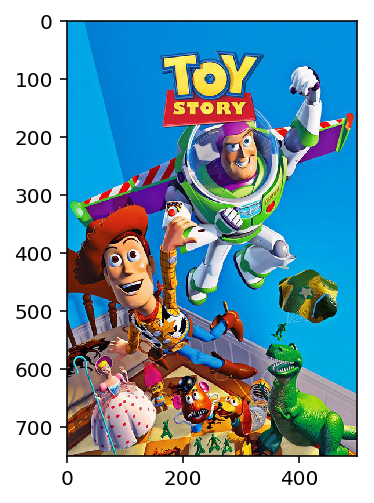

In [79]:
plt.imshow(plt.imread('data/movielens-100k/image/1.jpg'))

## Cora

In [ ]:
from graphsage.model import load_cora

In [ ]:
feat_data, labels, adj_lists = load_cora()
num_nodes, num_feats = feat_data.shape
num_classes = len(np.unique(labels))

num_nodes, num_feats, num_classes

In [ ]:
# Optional: Remove features and use identity matrix instead. 
# Set learning rate to 10 for this.
feat_data = np.eye(num_nodes)
num_feats = num_nodes

num_nodes, num_feats, num_classes

# GCN Layers

In [15]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, num_nodes, in_features_func, adj_dict, num_sample=10, activation=F.relu):
        nn.Module.__init__(self)
        self.in_features = in_features
        self.out_features = out_features
        self.in_features_func = in_features_func
        self.adj_dict = adj_dict
        # TODO: Add adj_array (see RelationalGraphConvolution).
        self.num_sample = num_sample
        self.activation = activation
        
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform(self.weight)
        
        
    # TODO: Profile this with lprun and see how much time each step takes up (especially creating the tensors!).
    def aggregate(self, nodes, adj_dict, include_self=False):
        """Return a vector for each node in `nodes` by mean-aggregating feature vectors from its neighborhood (or a sample thereof)."""
        
        # Step 1: For each node, sample some neighbors that we aggregate information from. 
        
        # TODO: Move this up to constructor or even outside of this class.
        #adj_array = np.array([adj_dict[i] for i in range(num_nodes)])
        #sampled_neighbors_per_node = adj_array[nodes]
        #print(sampled_neighbors_per_node)
        sampled_neighbors_per_node = [adj_dict[node] for node in nodes]
        
        # TODO: Replace stuff below by this line, check if it works.
        #sampled_neighbors_per_node = [adj_lists[node].update([node]) if include_self else adj_lists[node] for node in nodes]
        
        # TODO: Check if this improves the network. 
        #       Also, in graphsage, this is done after the sampling step (which doesn't make much sense though).
        # TODO: Check that node is not added to adj_lists permanently.
        if include_self:
            for sampled_neighbors, node in zip(sampled_neighbors_per_node, nodes):
                sampled_neighbors.add(node)
        
        if self.num_sample is not None:
            # TODO: See if local pointers bring speed improvements (see GraphSage code).
            for i in range(len(sampled_neighbors_per_node)):
                if self.num_sample <= len(sampled_neighbors_per_node[i]):
                    sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], self.num_sample))
                    
                    
        # Step 2: Find the unique neighbors in all sampled neighbors.
        
        unique_neighbors = list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        if unique_neighbors:
            
            # Step 3: Get embeddings for these unique neighbors from the underlying layer 
            #         (e.g. another GraphConvolution layer or a fixed feature matrix).
            
            unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
            if self.is_cuda():
                unique_neighbors_tensor = unique_neighbors_tensor.cuda()
            unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor)
            

            # Step 4: For each input node, sum the embeddings of its (sampled) neighbors, 
            #         using the embeddings obtained above. The algorithm here uses a masking matrix 
            #         to find the neighbor embeddings for each node and add them in one step. 
            
            # TODO: See if this can be implemented in an easier way (i.e. without mask).
            
            # TODO: Check if this really needs to be a variable.
            # TODO: Maybe store mask in self and fill it with zeros here, so it doesn't have to initalized in each forward pass. 
            mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
            if self.is_cuda():
                mask = mask.cuda()
            # TODO: Understand and rename variables here.
            column_indices = [unique_neighbors_to_index[neighbor] for sampled_neighbors in sampled_neighbors_per_node for neighbor in sampled_neighbors]
            row_indices = [i for i in range(len(sampled_neighbors_per_node)) for j in range(len(sampled_neighbors_per_node[i]))]
            mask[row_indices, column_indices] = 1

            # TODO: Is this actually the number of neighbors, i.e. does it correspond 
            #       to the normalization constant in RGCN paper?
            num_neighbors = mask.sum(1, keepdim=True)
            mask /= num_neighbors + 1e-10  # prevent zero division
            
            #set_trace()
            
            # TODO: Check what the actual output of this term is.
            return mask.mm(unique_neighbors_embeddings)
        else:
            # TODO: If there are no neighbors, this currently returns a zero vector. Is this correct?
            # TODO: Building this variable and moving it to cuda takes up a lot of time (15 % for Link Prediction),
            #       speed this up somehow.
            zeros = Variable(torch.zeros(len(nodes), self.in_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            return zeros

        
    def forward(self, nodes):
        neighborhood_features = self.aggregate(nodes, self.adj_dict, include_self=True)
        
        # TODO: Maybe add features of nodes themselves,
        #       or include nodes themselves in sampling process in aggregate function (as in GraphSAGE,
        #       but collides with RGCN use of aggregate function).
        #node_features = self.in_features_func(torch.LongTensor(nodes))
        
        return self.activation(neighborhood_features.mm(self.weight.t()))
    
    def is_cuda(self):
        return self.weight.is_cuda

In [13]:
# Old version that can deal with a single relation per edge.
class RelationalGraphConvolution(GraphConvolution):
    def __init__(self, in_features, out_features, num_nodes, num_relations, in_features_func, relational_adj_dict, 
                 num_sample=10, activation=F.relu):
        
        super(RelationalGraphConvolution, self).__init__(in_features, out_features, num_nodes, in_features_func, None, num_sample, activation)
        
        # TODO: Maybe create adj_dict from train_triples directly in here.
        self.relational_adj_dict = relational_adj_dict
        self.adj_array = np.array([set(relational_adj_dict[i].keys()) for i in range(num_nodes)], dtype=object)
        
        self.num_relations = num_relations
        
        # TODO: Maybe store the relation weights in a 3D tensor instead of a ParameterList. 
        #       Uses about the same amount of memory. Check if it brings speed improvements.
        self.relation_weights = nn.ParameterList()
        for relation in range(num_relations):
            self.relation_weights.append(nn.Parameter(torch.FloatTensor(out_features, in_features)))
            nn.init.xavier_uniform(self.relation_weights[relation])
        #self.weights_per_relation = nn.Parameter(torch.FloatTensor(num_relations, out_features, in_features))
            
    def forward(self, nodes):
        # TODO: Refactor this by passing nodes as tensor in the first place.
        if type(nodes) == torch.LongTensor or type(nodes) == torch.cuda.LongTensor:
            nodes_tensor = nodes
        else:
            nodes_tensor = torch.LongTensor(nodes)
            if self.is_cuda():
                nodes_tensor = nodes_tensor.cuda()
                
        # Step 1: Get embeddings for all nodes in the mini-batch from the underlying layer.
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        input_embeddings = self.in_features_func(nodes_tensor)
        output_embeddings = input_embeddings.mm(self.weight.t())  # terms for relations will be added to this
                
                
        # Step 2: For each node, sample some neighbors that we aggregate information from. 
        #sampled_neighbors_per_node = [set(self.relational_adj_dict[node]) for node in nodes]
        # TODO: Refactor this to method sample_neighbors(nodes), which uses self.num_sample and self.relational_adj_dict.
        sampled_neighbors_per_node = self.adj_array[nodes]
        if self.num_sample is not None:
            # TODO: Check if local pointers bring speed improvements (see GraphSage code).
            for i in range(len(sampled_neighbors_per_node)):
                if self.num_sample <= len(sampled_neighbors_per_node[i]):
                    # TODO: Check if np.random.choice is faster.
                    sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], self.num_sample))
            
        # Step 3: Find the unique neighbors in all sampled neighbors. 
        #         If there are no unique neighbors, return zero embeddings.
        unique_neighbors = list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        if not unique_neighbors:
            # TODO: Maybe create and store this once, and return it each time here.
            zeros = Variable(torch.zeros(len(nodes), self.out_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            print('No unique neighbors, returning zero. Nodes:', nodes)
            return zeros
        
        # Step 3: Get embeddings for these unique neighbors from the underlying layer 
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        # TODO: Investigate how much time processing only the unique neighbors actually saves vs the overhead 
        #       done here to reassign unique neighbors to the nodes (for a realistiv batch size!)
        unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
        if self.is_cuda():
            unique_neighbors_tensor = unique_neighbors_tensor.cuda()
        unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor)
                
        # Step 4: For each relation, average the embeddings of sampled neighbors, 
        #         using the embeddings obtained above. The algorithm here uses a masking matrix 
        #         to find the neighbor embeddings for each node and add them in one step. 
        mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
        if self.is_cuda():
            mask = mask.cuda()

        for relation in range(num_relations):
            # TODO: Check which of these three alternatives for masking is quickest:
            #       1) Iterate over all nodes and sampled neighbor, and assign column/row indices only 
            #          if edge has relation (current method).
            #          Potentially iterates very often over the same arrays.
            #       2) Compile one object sampled_neighbors_per_node_per_relation beforehand, 
            #          and do the usual mask-building for each relation in there.
            #       3) Build one mask for each relation and set values in the mask belonging 
            #          to the relation directly.

            column_indices = []
            for node, sampled_neighbors in zip(nodes, sampled_neighbors_per_node):
                for neighbor in sampled_neighbors:
                    if self.relational_adj_dict[node][neighbor] == relation:
                    #if relation in self.relational_adj_dict[node][neighbor]:
                        column_indices.append(unique_neighbors_to_index[neighbor])
                        
            if column_indices:  # if column_indices is empty, there are no sampled neighbors with this relation, so skip it
                row_indices = []
                for i, node in enumerate(nodes):
                    for j, neighbor in enumerate(sampled_neighbors_per_node[i]):
                        if self.relational_adj_dict[node][neighbor] == relation:
                        #if relation in self.relational_adj_dict[node][neighbor]:
                            row_indices.append(i)

                mask[row_indices, column_indices] = 1
                
                # TODO: Here, I divide by the number of neighbors with this relation.
                #       In R-GCN paper, they divide by the number of all neighbors (across relations).
                #       Implement this by summing up these values over all relations.
                #       Also ask Michael, how the results with other normalization constants were.
                num_neighbors_per_node = mask.sum(1, keepdim=True)
                mask /= num_neighbors_per_node + 1e-10  # prevent zero division

                # Non-zero value at (i, j) in mask means that embedding of unique neighbor j contributes 
                # to aggregated embedding for node i (weighted by the value in mask). Formally:
                # aggregated_node_embeddings[i] = \sum_j {mask[i, j] * unique_neighbors_embeddings[j]}
                aggregated_embeddings = mask.mm(unique_neighbors_embeddings)

                # Step 5: Multiply the aggregated feature vectors with the relation-specific weight matrix.
                output_embeddings += aggregated_embeddings.mm(self.relation_weights[relation].t())

            return self.activation(output_embeddings)

In [16]:
# New version that can deal with multiple relations per edge.
class RelationalGraphConvolution(GraphConvolution):
    def __init__(self, in_features, out_features, num_nodes, num_relations, in_features_func, relational_adj_dict, 
                 num_sample=10, activation=F.relu):
        
        super(RelationalGraphConvolution, self).__init__(in_features, out_features, num_nodes, in_features_func, None, num_sample, activation)
        
        # TODO: Maybe create adj_dict from train_triples directly in here.
        self.relational_adj_dict = relational_adj_dict
        self.adj_array = np.array([set(relational_adj_dict[i].keys()) for i in range(num_nodes)], dtype=object)
        
        self.num_relations = num_relations
        
        # TODO: Maybe store the relation weights in a 3D tensor instead of a ParameterList. 
        #       Uses about the same amount of memory. Check if it brings speed improvements.
        self.relation_weights = nn.ParameterList()
        for relation in range(num_relations):
            self.relation_weights.append(nn.Parameter(torch.FloatTensor(out_features, in_features)))
            nn.init.xavier_uniform(self.relation_weights[relation])
        #self.weights_per_relation = nn.Parameter(torch.FloatTensor(num_relations, out_features, in_features))
            
    def forward(self, nodes):
        # TODO: Refactor this by passing nodes as tensor in the first place.
        if type(nodes) == torch.LongTensor or type(nodes) == torch.cuda.LongTensor:
            nodes_tensor = nodes
        else:
            nodes_tensor = torch.LongTensor(nodes)
            if self.is_cuda():
                nodes_tensor = nodes_tensor.cuda()
                
        # Step 1: Get embeddings for all nodes in the mini-batch from the underlying layer.
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        input_embeddings = self.in_features_func(nodes_tensor)
        output_embeddings = input_embeddings.mm(self.weight.t())  # terms for relations will be added to this
                
                
        # Step 2: For each node, sample some neighbors that we aggregate information from. 
        #sampled_neighbors_per_node = [set(self.relational_adj_dict[node]) for node in nodes]
        # TODO: Refactor this to method sample_neighbors(nodes), which uses self.num_sample and self.relational_adj_dict.
        sampled_neighbors_per_node = self.adj_array[nodes]
        if self.num_sample is not None:
            # TODO: Check if local pointers bring speed improvements (see GraphSage code).
            for i in range(len(sampled_neighbors_per_node)):
                if self.num_sample <= len(sampled_neighbors_per_node[i]):
                    # TODO: Check if np.random.choice is faster.
                    sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], self.num_sample))
            
        # Step 3: Find the unique neighbors in all sampled neighbors. 
        #         If there are no unique neighbors, return zero embeddings.
        unique_neighbors = list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        if not unique_neighbors:
            # TODO: Maybe create and store this once, and return it each time here.
            zeros = Variable(torch.zeros(len(nodes), self.out_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            print('No unique neighbors, returning zero. Nodes:', nodes)
            return zeros
        
        # Step 3: Get embeddings for these unique neighbors from the underlying layer 
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        # TODO: Investigate how much time processing only the unique neighbors actually saves vs the overhead 
        #       done here to reassign unique neighbors to the nodes (for a realistiv batch size!)
        unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
        if self.is_cuda():
            unique_neighbors_tensor = unique_neighbors_tensor.cuda()
        unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor)
                
        # Step 4: For each relation, average the embeddings of sampled neighbors, 
        #         using the embeddings obtained above. The algorithm here uses a masking matrix 
        #         to find the neighbor embeddings for each node and add them in one step. 
        mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
        if self.is_cuda():
            mask = mask.cuda()

        for relation in range(num_relations):
            # TODO: Check which of these three alternatives for masking is quickest:
            #       1) Iterate over all nodes and sampled neighbor, and assign column/row indices only 
            #          if edge has relation (current method).
            #          Potentially iterates very often over the same arrays.
            #       2) Compile one object sampled_neighbors_per_node_per_relation beforehand, 
            #          and do the usual mask-building for each relation in there.
            #       3) Build one mask for each relation and set values in the mask belonging 
            #          to the relation directly.

            column_indices = []
            for node, sampled_neighbors in zip(nodes, sampled_neighbors_per_node):
                for neighbor in sampled_neighbors:
                    #if self.relational_adj_dict[node][neighbor] == relation:
                    if relation in self.relational_adj_dict[node][neighbor]:
                        column_indices.append(unique_neighbors_to_index[neighbor])
                        
            if column_indices:  # if column_indices is empty, there are no sampled neighbors with this relation, so skip it
                row_indices = []
                for i, node in enumerate(nodes):
                    for j, neighbor in enumerate(sampled_neighbors_per_node[i]):
                        #if self.relational_adj_dict[node][neighbor] == relation:
                        if relation in self.relational_adj_dict[node][neighbor]:
                            row_indices.append(i)

                mask[row_indices, column_indices] = 1
                
                # TODO: Here, I divide by the number of neighbors with this relation.
                #       In R-GCN paper, they divide by the number of all neighbors (across relations).
                #       Implement this by summing up these values over all relations.
                #       Also ask Michael, how the results with other normalization constants were.
                num_neighbors_per_node = mask.sum(1, keepdim=True)
                mask /= num_neighbors_per_node + 1e-10  # prevent zero division

                # Non-zero value at (i, j) in mask means that embedding of unique neighbor j contributes 
                # to aggregated embedding for node i (weighted by the value in mask). Formally:
                # aggregated_node_embeddings[i] = \sum_j {mask[i, j] * unique_neighbors_embeddings[j]}
                aggregated_embeddings = mask.mm(unique_neighbors_embeddings)

                # Step 5: Multiply the aggregated feature vectors with the relation-specific weight matrix.
                output_embeddings += aggregated_embeddings.mm(self.relation_weights[relation].t())

            return self.activation(output_embeddings)

In [ ]:
# New version that uses triples directly.
# TODO: Check runtime and performance against old version.
class RelationalGraphConvolution(GraphConvolution):
    def __init__(self, in_features, out_features, num_nodes, num_relations, in_features_func, train_triples, 
                 num_sample=10, activation=F.relu):
        
        super(RelationalGraphConvolution, self).__init__(in_features, out_features, num_nodes, in_features_func, None, num_sample, activation)
        
        # TODO: Maybe create adj_dict from train_triples directly in here.
        #self.relational_adj_dict = relational_adj_dict
        #self.adj_array = np.array([set(relational_adj_dict[i].keys()) for i in range(num_nodes)], dtype=object)
        self.train_triples = train_triples.copy()
        
        self.num_relations = num_relations
        
        # TODO: Maybe store the relation weights in a 3D tensor instead of a ParameterList. 
        #       Uses about the same amount of memory. Check if it brings speed improvements.
        self.relation_weights = nn.ParameterList()
        for relation in range(num_relations):
            self.relation_weights.append(nn.Parameter(torch.FloatTensor(out_features, in_features)))
            nn.init.xavier_uniform(self.relation_weights[relation])
        #self.weights_per_relation = nn.Parameter(torch.FloatTensor(num_relations, out_features, in_features))
            
    def forward(self, nodes):
        # TODO: Refactor this by passing nodes as tensor in the first place.
        if type(nodes) == torch.LongTensor or type(nodes) == torch.cuda.LongTensor:
            nodes_tensor = nodes
        else:
            nodes_tensor = torch.LongTensor(nodes)
            if self.is_cuda():
                nodes_tensor = nodes_tensor.cuda()
                
        # Step 1: Get embeddings for all nodes in the mini-batch from the underlying layer.
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        input_embeddings = self.in_features_func(nodes_tensor)
        output_embeddings = input_embeddings.mm(self.weight.t())  # terms for relations will be added to this
                
                
        # Step 2: For each node, sample some neighbors that we aggregate information from. 
        #sampled_neighbors_per_node = [set(self.relational_adj_dict[node]) for node in nodes]
        # TODO: Refactor this to method sample_neighbors(nodes), which uses self.num_sample and self.relational_adj_dict.
#         sampled_neighbors_per_node = self.adj_array[nodes]
#         if self.num_sample is not None:
#             # TODO: Check if local pointers bring speed improvements (see GraphSage code).
#             for i in range(len(sampled_neighbors_per_node)):
#                 if self.num_sample <= len(sampled_neighbors_per_node[i]):
#                     # TODO: Check if np.random.choice is faster.
#                     sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], self.num_sample))
        # TODO: Check how long this takes. Maybe create triples_per_node for all nodes in constructor.
        sampled_triples_per_node = [train_triples[train_triples[:, 0] == node] for node in nodes]
        if self.num_sample is not None:
            for i in range(len(sampled_triples_per_node)):
                if self.num_sample <= len(sampled_triples_per_node[i]):
                    sampled_triples_per_node[i] = sampled_triples_per_node[i][np.random.choice(len(sampled_triples_per_node[i], size=self.num_sample))]

            
        # Step 3: Find the unique neighbors in all sampled neighbors. 
        #         If there are no unique neighbors, return zero embeddings.
        unique_neighbors = np.unique(np.hstack([sampled_triples[:, 1] for sampled_triples in sampled_triples_per_neighbor]))#list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        # TODO: Check if this works with array.
        if not unique_neighbors:
            # TODO: Maybe create and store this once, and return it each time here.
            zeros = Variable(torch.zeros(len(nodes), self.out_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            print('No unique neighbors, returning zero. Nodes:', nodes)
            return zeros
        
        # Step 3: Get embeddings for these unique neighbors from the underlying layer 
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        # TODO: Investigate how much time processing only the unique neighbors actually saves vs the overhead 
        #       done here to reassign unique neighbors to the nodes (for a realistiv batch size!)
        unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
        if self.is_cuda():
            unique_neighbors_tensor = unique_neighbors_tensor.cuda()
        unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor)
                
        # Step 4: For each relation, average the embeddings of sampled neighbors, 
        #         using the embeddings obtained above. The algorithm here uses a masking matrix 
        #         to find the neighbor embeddings for each node and add them in one step. 
        mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
        if self.is_cuda():
            mask = mask.cuda()

        for relation in range(num_relations):
            # TODO: Check which of these three alternatives for masking is quickest:
            #       1) Iterate over all nodes and sampled neighbor, and assign column/row indices only 
            #          if edge has relation (current method).
            #          Potentially iterates very often over the same arrays.
            #       2) Compile one object sampled_neighbors_per_node_per_relation beforehand, 
            #          and do the usual mask-building for each relation in there.
            #       3) Build one mask for each relation and set values in the mask belonging 
            #          to the relation directly.

            column_indices = []
            for node, sampled_neighbors in zip(nodes, sampled_neighbors_per_node):
                for neighbor in sampled_neighbors:
                    if relation in self.relational_adj_dict[node][neighbor]:
                        column_indices.append(unique_neighbors_to_index[neighbor])
                        
            if column_indices:  # if column_indices is empty, there are no sampled neighbors with this relation, so skip it
                row_indices = []
                for i, node in enumerate(nodes):
                    for j, neighbor in enumerate(sampled_neighbors_per_node[i]):
                        if relation in self.relational_adj_dict[node][neighbor]:
                            row_indices.append(i)

                mask[row_indices, column_indices] = 1
                
                # TODO: Here, I divide by the number of neighbors with this relation.
                #       In R-GCN paper, they divide by the number of all neighbors (across relations).
                #       Implement this by summing up these values over all relations.
                #       Also ask Michael, how the results with other normalization constants were.
                num_neighbors_per_node = mask.sum(1, keepdim=True)
                mask /= num_neighbors_per_node + 1e-10  # prevent zero division

                # Non-zero value at (i, j) in mask means that embedding of unique neighbor j contributes 
                # to aggregated embedding for node i (weighted by the value in mask). Formally:
                # aggregated_node_embeddings[i] = \sum_j {mask[i, j] * unique_neighbors_embeddings[j]}
                aggregated_embeddings = mask.mm(unique_neighbors_embeddings)

                # Step 5: Multiply the aggregated feature vectors with the relation-specific weight matrix.
                output_embeddings += aggregated_embeddings.mm(self.relation_weights[relation].t())

            return self.activation(output_embeddings)

# Supervised Classification (without relations and features)

In [16]:
class SupervisedGCN(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = GraphConvolution(num_features, 128, features, adj_lists, activation=F.relu)
        self.graph_conv2 = GraphConvolution(128, 128, self.graph_conv1, adj_lists, activation=F.relu)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(128, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        node_embeddings = self.graph_conv2(nodes)  # implicitly calls underlying conv layers
        scores = self.dense(node_embeddings)
        return scores

In [17]:
# Run algorithm.
np.random.seed(1)
random.seed(1)

use_cuda = True

net = SupervisedGCN(num_classes, feat_data, adj_dict)
if use_cuda and torch.cuda.is_available():
    print('Moving network to GPU.')
    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

times = []
for batch in range(100):
    #batch_nodes = Variable(torch.LongTensor(train[:256]), requires_grad=False)
    batch_nodes = train[:256]
    random.shuffle(train)
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        target = target.cuda()
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1), average="micro"))
        print("Average batch time:", np.mean(times))

Moving network to GPU.
0 0.692896485329
Validation Accuracy: 0.634
Validation F1: 0.634
Average batch time: 0.1904129981994629
1 0.667886972427
2 0.612422704697
3 0.529688358307
4 0.42939171195
5 0.319299668074
6 0.250481367111
7 0.250862538815
8 0.194756746292
9 0.183181121945
10 0.152682065964
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06710889122702858
11 0.123559959233
12 0.0772185176611
13 0.0510042309761
14 0.0365696884692
15 0.0187319889665
16 0.0101769454777
17 0.00538808479905
18 0.00236057955772
19 0.000963839702308
20 0.000447682105005
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06511790411812919
21 0.00017000362277
22 8.49878415465e-05
23 3.43294814229e-05
24 1.98967754841e-05
25 1.02631747723e-05
26 4.99188899994e-06
27 2.59838998318e-06
28 1.47707760334e-06
29 2.25566327572e-06
30 1.52364373207e-06
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06462906252953314
31 4.22820448875e-07
32 1.02631747723e-06
33 6.

In [174]:
# Alternative version with epochs and progressbar.
# TODO: Update CUDA support.

from tqdm import tqdm

# Run algorithm.
np.random.seed(1)
random.seed(1)

net = SupervisedGCN(num_classes, feat_data, adj_lists)
#    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

num_epochs = 10
batch_size = 256

for epoch in range(1, num_epochs+1):
    
    
    #tqdm.write('Epoch {}/{}:'.format(epoch, num_epochs-1))

    random.shuffle(train)
    num_batches = int(len(train) / batch_size)
    
    with tqdm(total=num_batches, desc='Epoch {}/{}'.format(epoch, num_epochs), ncols=110) as pbar:

        for batch in range(num_batches):

            #print('\tBatch {}/{}:'.format(batch, num_batches-1), end=' ')

            from_node = batch * batch_size
            to_node = min((batch + 1) * batch_size, len(train))
            batch_nodes = train[from_node:to_node]

            optimizer.zero_grad()

            output = net(batch_nodes)
            target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=loss.data[0])
            #print(loss.data[0])
            
            pbar.update()

        val_output = net(val) 
        val_acc = accuracy_score(labels[val], val_output.data.numpy().argmax(axis=1))
        val_f1 = f1_score(labels[val], val_output.data.numpy().argmax(axis=1), average="micro")
        pbar.set_postfix(loss=loss.data[0], val_acc=val_acc, val_f1=val_f1)


Epoch 10/10: 100%|██████████████████████████| 6/6 [00:01<00:00,  6.64it/s, loss=1.61e-13, val_acc=1, val_f1=1]


# Supervised Classification with relations

In [16]:
class SupervisedRGCN(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists_per_relation):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = RelationalGraphConvolution(num_features, 128, features, adj_lists_per_relation)
        self.graph_conv2 = RelationalGraphConvolution(128, 128, self.graph_conv1, adj_lists_per_relation)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(128, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        node_embeddings = self.graph_conv2(nodes)  # implicitly calls underlying conv layers
        #print(node_embeddings.sum())
        scores = self.dense(node_embeddings)  # softmax is applied by CrossEntropyLoss
        return scores


In [19]:
# Run algorithm.
np.random.seed(1)
random.seed(1)

use_cuda = True

net = SupervisedRGCN(num_classes, feat_data, adj_lists_per_relation)
if use_cuda and torch.cuda.is_available():
    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])
print('Training on', len(train), 'nodes')

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

times = []
for batch in range(100):
    #batch_nodes = Variable(torch.LongTensor(train[:256]), requires_grad=False)
    
    random.shuffle(train)
    batch_nodes = train[:256]
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        target = target.cuda()
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1), average="micro"))
        print("Average batch time:", np.mean(times))

Training on 1625 nodes
0 0.690665960312
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.19429492950439453
1 0.56970000267
2 0.422767162323
3 0.333146989346
4 0.244888827205
5 0.187118723989
6 0.116868980229
7 0.0616429522634
8 0.031066134572
9 0.0174713600427
10 0.00768253672868
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.1721870248967951
11 0.00573282269761
12 0.00264684483409
13 0.00133715290576
14 0.00102490792051
15 0.00063599832356
16 0.000389914028347
17 0.000162918586284
18 0.000254969578236
19 0.000120875425637
20 8.7134540081e-06
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.16201589221046084
21 8.99191945791e-06
22 1.94106251001e-05
23 1.6987323761e-06
24 1.47707760334e-06
25 3.20374965668e-07
26 4.7042965889e-05
27 1.33737921715e-05
28 8.17980617285e-06
29 8.38190317154e-08
30 1.30385160446e-07
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.1524044159919985
31 2.64495611191e-07
32 1.63912773132e-0

# Link Prediction

In [17]:
class DistMultScorer(nn.Module):
    
    def __init__(self, embedding_size, num_relations):
        nn.Module.__init__(self)
        self.relation_embedding = nn.Embedding(num_relations, embedding_size)
        nn.init.xavier_normal(self.relation_embedding.weight)
        
    def forward(self, subject_embeddings, object_embeddings, relations):
        # TODO: Give relations as tensor in the first place.
        relations_tensor = Variable(torch.LongTensor(relations), requires_grad=False)
        if self.relation_embedding.weight.is_cuda:
            relations_tensor = relations_tensor.cuda()
            
        relation_embeddings = self.relation_embedding(relations_tensor)
        scores = (subject_embeddings * relation_embeddings * object_embeddings).sum(1, keepdim=True)
        
        return scores

In [18]:
# Pure DistMult for baseline.
class DistMult(nn.Module):
    
    def __init__(self, embedding_size, num_nodes, num_relations, input_dropout_rate=0):
        super(DistMult, self).__init__()
        self.entity_embedding = nn.Embedding(num_nodes, embedding_size)
        self.scorer = DistMultScorer(embedding_size, num_relations)
        self.input_dropout = torch.nn.Dropout(input_dropout_rate)
        nn.init.xavier_normal(self.entity_embedding.weight)
        
        
    def forward(self, triples):
        # TODO: Give triples as variables here in the first place.
        subject_tensor = Variable(torch.LongTensor(triples[:, 0]), requires_grad=False)
        if self.entity_embedding.weight.is_cuda:
            subject_tensor = subject_tensor.cuda()
            
        subject_embeddings = self.entity_embedding(subject_tensor)
        subject_embeddings = self.input_dropout(subject_embeddings)
            
        object_tensor = Variable(torch.LongTensor(triples[:, 1]), requires_grad=False)
        if self.entity_embedding.weight.is_cuda:
            object_tensor = object_tensor.cuda()
            
        object_embeddings = self.entity_embedding(object_tensor)
        object_embeddings = self.input_dropout(object_embeddings)
            
        return self.scorer(subject_embeddings, object_embeddings, triples[:, 2])
    
    # TODO: Dirty workaround for ranking evaluation. Handle triples/entities as tensors everywhere, than this (net.get_embeddings) can be substituted by net.entitiy_embedding
    def get_embeddings(self, entities):
        entities_tensor = Variable(torch.LongTensor(entities), requires_grad=False)
        if self.entity_embedding.weight.is_cuda:
            entities_tensor = entities_tensor.cuda()
            
        return self.entity_embedding(entities_tensor)

In [19]:
class UnsupervisedRGCN(nn.Module):

    # TODO: Add Dropout.
    # TODO: Rename feat_data to node_features. 
    def __init__(self, feat_data, relational_adj_dict, num_relations, embedding_size=128, num_sample=10):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        
        features_embedding = nn.Embedding(num_nodes, num_features)
        features_embedding.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        # TODO: Maybe move num_relations to third parameter.
        self.graph_conv1 = RelationalGraphConvolution(num_features, embedding_size, num_nodes, num_relations, 
                                                      features_embedding, relational_adj_dict, 
                                                      num_sample)
        self.graph_conv2 = RelationalGraphConvolution(embedding_size, embedding_size, num_nodes, num_relations, 
                                                      self.graph_conv1, relational_adj_dict, 
                                                      num_sample)
        
        self.dist_mult = DistMultScorer(embedding_size, num_relations)
        
    def forward(self, triples):
        # TODO: This computes lots of duplicates if nodes appear in multiple triples or as subject and object.
        #       See if this can be improved by finding the unique nodes, running graph_conv2 on them once,
        #       and then merging this back. Could also be applied in GraphConvolution (in addition to here, 
        #       because GraphConvolution cannot consider duplicates in subject and object).
        #unique_nodes = set.union(set(triples[:, 0]), set(triples[:, 1]))
        #unique_nodes_to_index = {node: i for i, node in enumerate(unique_nodes)}
        
        #unique_nodes_features = self.graph_conv2(unique_nodes)
        #print(unique_nodes_features)
        
        from_node_embeddings = self.graph_conv2(triples[:, 0])  # implicitly calls underlying conv layers
        to_node_embeddings = self.graph_conv2(triples[:, 1])  # implicitly calls underlying conv layers
        
        scores = self.dist_mult(from_node_embeddings, to_node_embeddings, triples[:, 2])
        return scores

In [20]:
# Training utils for link prediction.

def sample_negatives(triples, num_nodes, num_negatives=1):
    """Return a copy of triples where either the subject or the object in each triple is replaced with a random entity."""
    corrupted_triples = []
    for i in range(num_negatives):
        for s, o, r in triples:
            if np.random.rand() < 0.5:
                corrupted_triples.append((np.random.randint(num_nodes), o, r))
            else:
                corrupted_triples.append((s, np.random.randint(num_nodes), r))
    return np.asarray(corrupted_triples)


class SimplifiedMarginRankingLoss(nn.MarginRankingLoss):
    """Same as torch.nn.MarginRankingLoss, but input1 is always higher than input2."""
    
    def __call__(self, input1, input2):
        target = Variable(torch.ones(input1.shape), requires_grad=False)
        if input1.is_cuda:
            target = target.cuda()
        return super(SimplifiedMarginRankingLoss, self).__call__(input1, input2, target)
       
        

In [21]:
# Ranking evaluation.

def in2d(ar1, ar2):
    """
    Return indices of rows of `ar1` that are equal to one of the rows in `ar2`.
    
    Inspired by: https://stackoverflow.com/questions/8317022/get-intersecting-rows-across-two-2d-numpy-arrays
    """
    nrows, ncols = ar1.shape
    dtype={'names': ['f{}'.format(i) for i in range(ncols)],
           'formats': ncols * [ar1.dtype]}

    return np.in1d(ar1.view(dtype), ar2.view(dtype))

        
class RankingEvaluation(object):
    
    def __init__(self, triples, num_nodes, filtered=False, show_progress=False):
        self.triples = triples
        self.num_nodes = num_nodes
        self.filtered = filtered
        
        
        if self.filtered:
            
            self.true_triples_subject_corrupted_per_triple = []
            self.true_triples_object_corrupted_per_triple = []
        
            # TODO: Refactor.
            for triple in tqdm_notebook(self.triples) if show_progress else self.triples:
                triples_subject_corrupted = np.zeros((self.num_nodes, 3), dtype=int)
                triples_subject_corrupted[:, 0] = np.arange(num_nodes)
                triples_subject_corrupted[:, 1] = triple[1]
                triples_subject_corrupted[:, 2] = triple[2]
                # TODO: Store these as indices or boolean arrays? Check what is faster overall.
                # TODO: This line takes up all of the time, speed it up.
                self.true_triples_subject_corrupted_per_triple.append(np.where(in2d(triples_subject_corrupted, triples_arr))[0])
                
                triples_object_corrupted = np.zeros((self.num_nodes, 3), dtype=int)
                triples_object_corrupted[:, 0] = triple[0]
                triples_object_corrupted[:, 1] = np.arange(num_nodes)
                triples_object_corrupted[:, 2] = triple[2]
                self.true_triples_object_corrupted_per_triple.append(np.where(in2d(triples_object_corrupted, triples_arr))[0])
                
                
    def _get_rank(self, scoring_model, subject_embeddings, object_embeddings, relations, n, true_triples=None):
        scores = scoring_model(subject_embeddings, object_embeddings, relations).cpu().data.numpy()
        score_true_triple = scores[n]
        
        if self.filtered:
            scores_corrupted_triples = np.delete(scores, true_triples)
            #print('Removed', len(scores) - len(scores_corrupted_triples), 'triples')
        else:
            scores_corrupted_triples = np.delete(scores, [n])
            
        rank = sp.stats.rankdata(-np.hstack([score_true_triple, scores_corrupted_triples]), 'ordinal')[0]  # apply negative so highest score is 
        
        #rank_unfiltered = sp.stats.rankdata(-scores, 'ordinal')[n]
        #print(rank, rank_unfiltered, '--> changed', rank_unfiltered-rank, 'ranks')
        
        return rank
    
    
    def __call__(self, embedding_model, scoring_model, verbose=False, show_progress=False):
        
        # TODO: Run prediction batched (e.g. by using utils.predict). 
        all_node_embeddings = embedding_model(np.arange(self.num_nodes))
        ranks = []

        for i, triple in enumerate(tqdm_notebook(self.triples)) if show_progress else enumerate(self.triples):
            #print(triple, ':', end=' ')

            repeated_subject_embedding = all_node_embeddings[triple[0]].expand(self.num_nodes, -1)
            repeated_object_embedding = all_node_embeddings[triple[1]].expand(self.num_nodes, -1)
            repeated_relation = np.repeat(triple[2], self.num_nodes)

            # TODO: Refactor this.
            rank_subject_corrupted = self._get_rank(scoring_model, all_node_embeddings, repeated_object_embedding, repeated_relation, triple[0], self.true_triples_subject_corrupted_per_triple[i] if self.filtered else None)
            ranks.append(rank_subject_corrupted)
            
            rank_object_corrupted = self._get_rank(scoring_model, repeated_subject_embedding, all_node_embeddings, repeated_relation, triple[1], self.true_triples_object_corrupted_per_triple[i] if self.filtered else None)
            ranks.append(rank_object_corrupted)
            
            # TODO: Check if these are more or less the same.
            if verbose: print(rank_subject_corrupted, rank_object_corrupted)
            
        ranks = np.asarray(ranks)
        
        def hits_at(n):
            return np.sum(ranks <= n) / len(ranks)
        
        del all_node_embeddings

        return np.mean(ranks), np.mean(1 / ranks), hits_at(1), hits_at(3), hits_at(10)

In [22]:
# Set up dataset splits and ranking evaluation. 
# TODO: Check that this works.
train, val, test = utils.train_val_test_split(triples_arr, val_size=5000, test_size=5000, random_state=0)

filtered = False
train_ranker = RankingEvaluation(train[:5000], num_nodes, filtered=filtered, show_progress=True)
val_ranker = RankingEvaluation(val[:5000], num_nodes, filtered=filtered, show_progress=True)

In [23]:
# Set up network, loss, optimizer and history logger. Start a new training run from here.
use_cuda = True

#net = DistMult(256, num_nodes, num_relations, 0.4)
net = UnsupervisedRGCN(feat_data, relational_adj_dict, num_relations, 200, 10)#256, 10)  # new
if use_cuda and torch.cuda.is_available():
    print('Moving network to GPU')
    net.cuda()
    
# TODO: Maybe move loss function to model.
loss_function = SimplifiedMarginRankingLoss(1)
parameters_to_optimize = filter(lambda parameter: parameter.requires_grad, net.parameters())
optimizer = torch.optim.Adam(parameters_to_optimize, lr=0.001)
print('Optimizing', len(parameters_to_optimize), 'parameters')

history = utils.History()

Moving network to GPU
Optimizing 477 parameters


In [24]:
# Training loop. Run this again to continue training on the same network. 

np.random.seed(1)
random.seed(1)

# TODO: Implement training via classification of correct/corrupted triples.

num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    
    # This is for classification training.
    # num_negatives = 2
    # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
    # print(train_and_negatives.shape)
    # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
    # y[:len(train), 0] = 1
    # if use_cuda and torch.cuda.is_available():
    #     y = y.cuda()
    # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
    # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

    batches = utils.split_into_batches(train, batch_size=batch_size, shuffle=True)
    batches = tqdm_notebook(batches)
    batches_history = utils.History()
    
    for batch, batch_triples in enumerate(batches):
        
        #print(batch, batch_triples.shape)

        optimizer.zero_grad()
        output = net(batch_triples)
        #print(output)
        #print(output.sum().data[0])
        output_negative = net(sample_negatives(batch_triples, num_nodes))

        loss = loss_function(output, output_negative)
        # loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        batches_history.log_metric('loss', loss.data[0])
        batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
        batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
        batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

        batches.set_postfix(batches_history.latest())
        
        # TODO: Check if this improves memory.
        del output, output_negative, loss
            

    net.eval()
    val_output = utils.predict(net, val, batch_size=32, move_to_cpu=True)
    val_output_negative = utils.predict(net, sample_negatives(val, num_nodes), batch_size=32, move_to_cpu=True)
    net.train()
    #net.eval()
    #val_output = net(val)
    #val_output_negative = net(sample_negatives(val, num_nodes))
    #net.train()
    
    # TODO: Implement these metrics in a batched fashion, then increase size of validation set.
    
    history.log_metric('loss', batches_history.mean('loss'), 
                       loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
    history.log_metric('acc', batches_history.mean('acc'), 
                       (val_output > val_output_negative).float().mean().data[0], 'Accuracy', print_=True)
    history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                       (val_output - val_output_negative).mean().data[0], 'Mean Difference', print_=True)
    history.log_metric('median_diff', batches_history.mean('median_diff'), 
                       (val_output - val_output_negative).median().data[0], 'Median Difference', print_=True)
    
    del val_output, val_output_negative

    print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
    print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
    mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(net.graph_conv2, net.dist_mult)#train_ranker(net.get_embeddings, net.scorer)
    val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(net.graph_conv2, net.dist_mult)#val_ranker(net.get_embeddings, net.scorer)
    history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
    history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
    history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
    history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
    history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

    
    print('-'*80)
    print()

Epoch 1/100


HBox(children=(IntProgress(value=0, max=8192), HTML(value=u'')))


Loss:       0.656102412442
Val Loss:   0.504275739193

Accuracy:       0.636821746826
Val Accuracy:   0.676599979401

Mean Difference:       1.10254188834
Val Mean Difference:   1.98342585564

Median Difference:       0.358228127635
Val Median Difference:   0.929238915443

Running rank evaluation for train in raw setting...
Running rank evaluation for val in raw setting...
Mean Rank:       1421.4698
Val Mean Rank:   1507.7923

Mean Rec Rank:       0.307163874488
Val Mean Rec Rank:   0.31021564477

Hits@1:       0.284
Val Hits@1:   0.2874

Hits@3:       0.3141
Val Hits@3:   0.3172

Hits@10:       0.3445
Val Hits@10:   0.3475

--------------------------------------------------------------------------------

Epoch 2/100


HBox(children=(IntProgress(value=0, max=8192), HTML(value=u'')))


Loss:       0.436337752668
Val Loss:   0.419402062893

Accuracy:       0.700045267742
Val Accuracy:   0.704200029373

Mean Difference:       2.69270269604
Val Mean Difference:   3.16148114204

Median Difference:       1.29548312745
Val Median Difference:   1.68796992302

Running rank evaluation for train in raw setting...
Running rank evaluation for val in raw setting...
Mean Rank:       950.6138
Val Mean Rank:   1036.1092

Mean Rec Rank:       0.3124380957
Val Mean Rec Rank:   0.31700699044

Hits@1:       0.2872
Val Hits@1:   0.2922

Hits@3:       0.3157
Val Hits@3:   0.3204

Hits@10:       0.3545
Val Hits@10:   0.3602

--------------------------------------------------------------------------------

Epoch 3/100


HBox(children=(IntProgress(value=0, max=8192), HTML(value=u'')))

KeyboardInterrupt: 

In [39]:
val_ranker(net.graph_conv2, net.dist_mult)

(722.3595, 0.24872336990780344, 0.2203, 0.2463, 0.2963)

In [23]:
utils.predict(net, val, batch_size=12, show_progress=True, move_to_cpu=True)

HBox(children=(IntProgress(value=0, max=417), HTML(value=u'')))

Variable containing:
 2.2283e-07
 1.1556e-05
-2.3874e-05
     ⋮      
 3.8097e-05
 1.9427e-05
-6.9625e-05
[torch.FloatTensor of size 5000x1]

In [27]:
%debug

> /home/jrieke/Projects/multimodal-gcn/utils.py(109)<genexpr>()
    107         return (arrays[0][batch_indices] for batch_indices in batch_indices_list)
    108     else:
--> 109         return ([arr[batch_indices] for arr in arrays] for batch_indices in batch_indices_list)
    110 
    111 

ipdb> arrays
[array([[ 1603,  3779,    10],
       [ 6167, 12532,    11],
       [10207, 10617,    10],
       ...,
       [ 9971, 13461,   191],
       [ 9547, 13211,    12],
       [  437,  1037,    68]]), array(128)]
ipdb> q


In [48]:
%lprun -f RelationalGraphConvolution.forward net(batch_triples)

In [ ]:
# Changes vs 4: Sample neighbors over all relations at once, raw ranking.

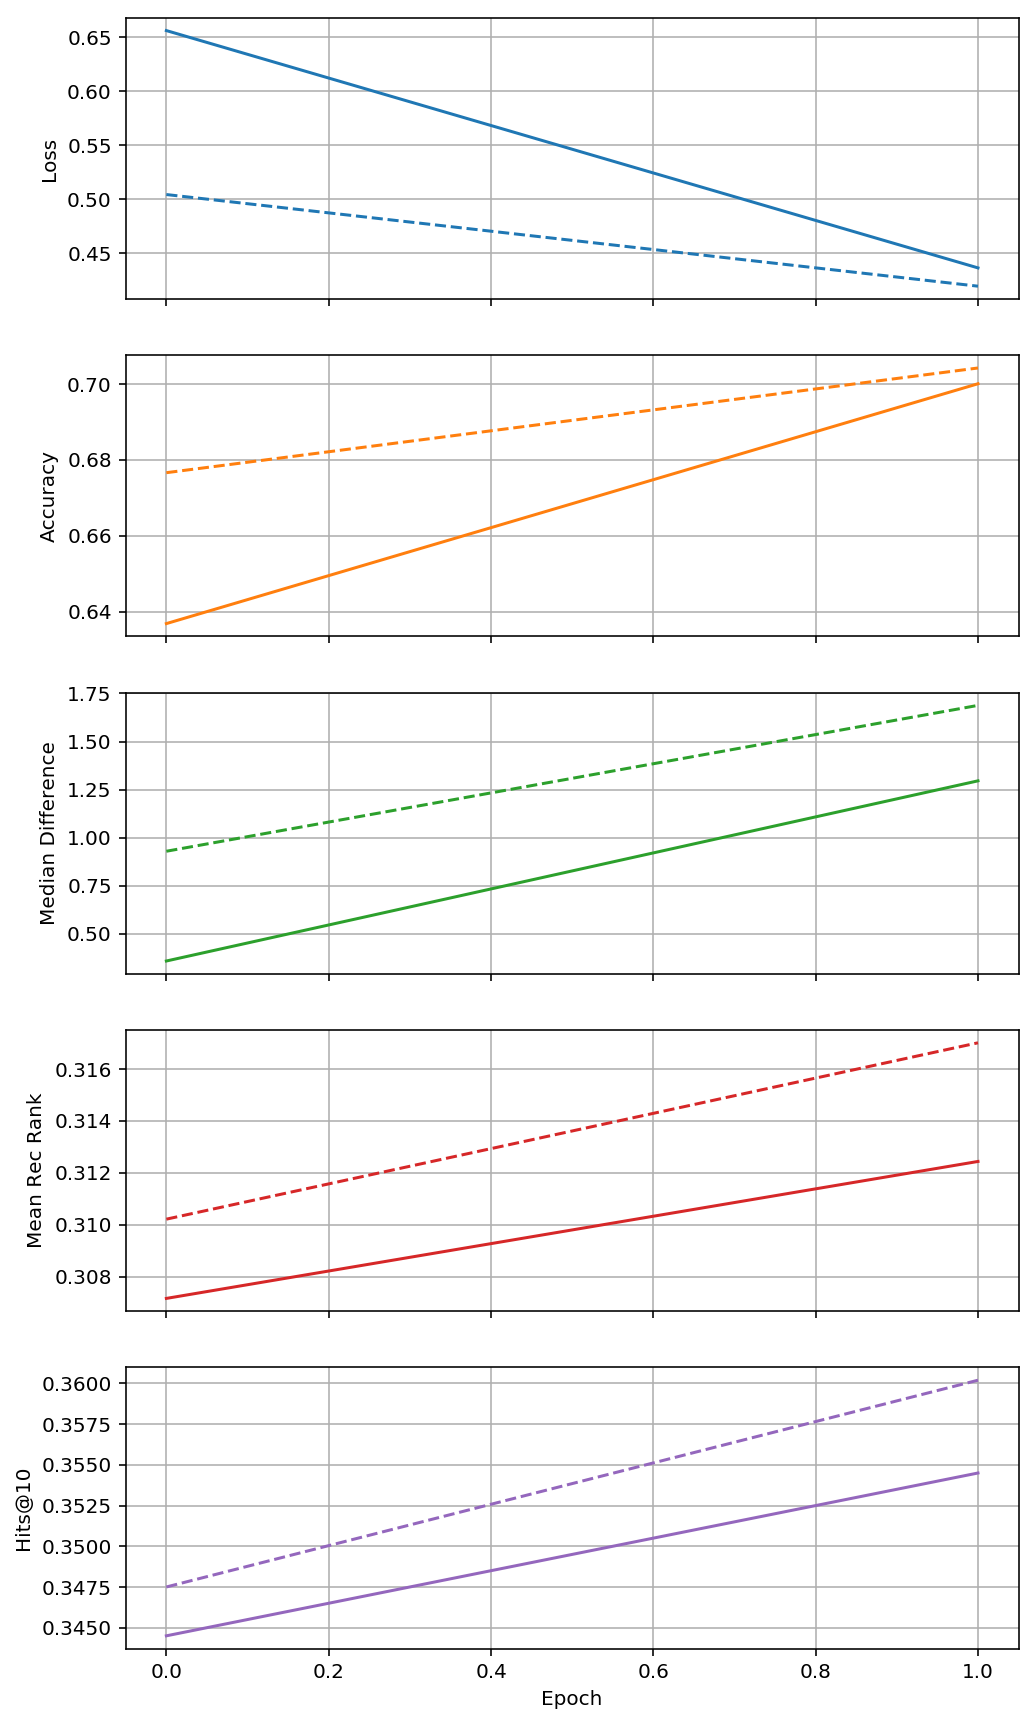

In [25]:
to_plot = ['loss', 'acc', 'median_diff', 'mean_rec_rank', 'hits_10']
figsize = (8, 15)

# TODO: Implement function to compare history objects in a plot.
history.plot(*to_plot, figsize=figsize)

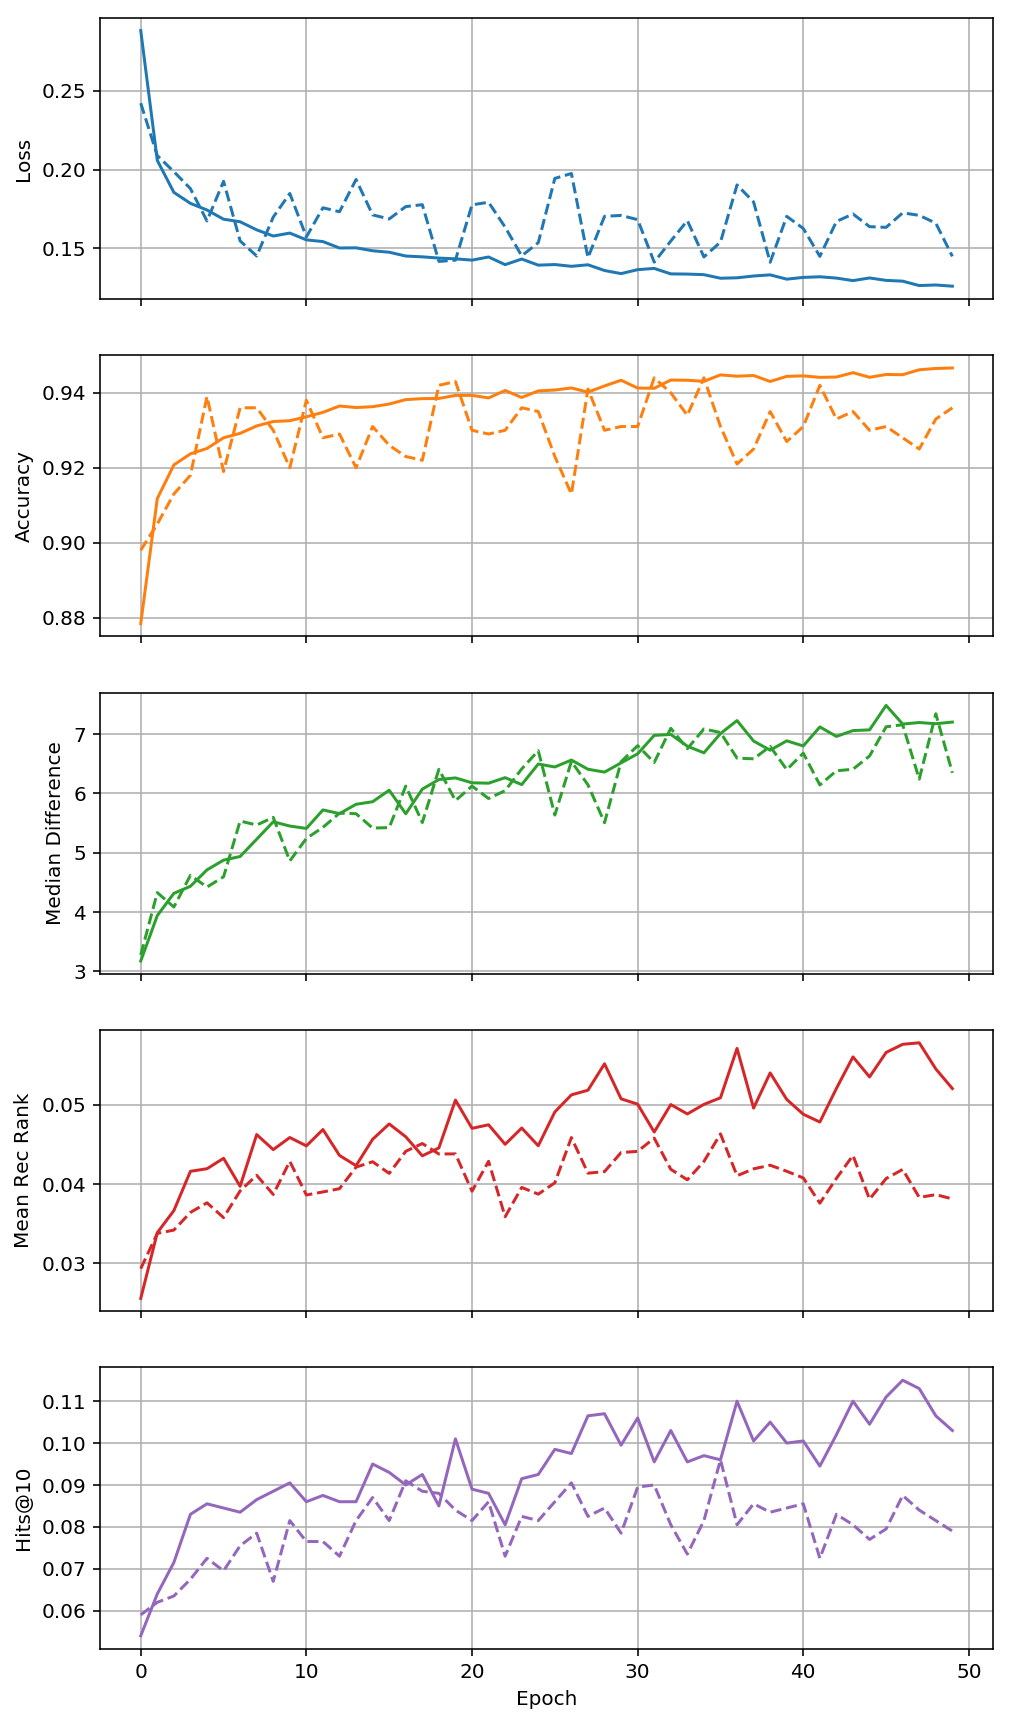

In [52]:
utils.History.load('logs/1_link-prediction-movielens-baseline.tsv').plot(*to_plot, figsize=figsize)

In [28]:
history.save('logs/7_multiple-relations-per-edge_raw-ranking-over-5000-samples.tsv')

In [29]:
!ls logs

1_link-prediction-movielens-baseline.tsv
2_filtered-ranking-evaluation.tsv
3_directed-edges-in-adj-lists.tsv
4_batch-size-128-and-refactoring.tsv
5_sampling-over-all-relations-and-raw-ranking-and-undirected-edges.tsv
6_fb15k-237_embedding-size-200_batch-size-32_raw-ranking-over-300-samples.tsv
